# Imports

In [1]:
import os, re, sys, pickle, datetime
import itertools
from itertools import repeat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
import copy

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression,Ridge,ElasticNetCV,ElasticNet,Lars,LassoCV,RidgeCV,LarsCV,LassoLarsCV,LassoLarsIC,OrthogonalMatchingPursuitCV,OrthogonalMatchingPursuit
from sklearn.manifold import TSNE,MDS
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut,cross_val_score,cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.svm import LinearSVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
#from sklearn import tree

import statsmodels.api as sm
import multiprocessing
from multiprocessing import Pool
n_processors = max([1,multiprocessing.cpu_count()-2])
from joblib import Parallel,delayed

import warnings
warnings.filterwarnings("ignore")

import loo_q2 as loo
from hotspot_classes import Threshold, Hotspot
import hotspot_utils

randomstate = 42

def plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.figure(figsize=(5,5))
    # plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker=".",facecolor='none',s=200)
    plt.scatter(y_train,y_pred_train,label="training",color="black",marker=".",s=200) # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="test",color='red',marker=".",linewidth=3, s=200)     #,alpha=0.25  "#8da9f5"
    plt.plot(y_train,yy_fit_line,color="darkgrey",linestyle='--',dashes=[5,15]) #,alpha=0.2
    if leg:
        plt.legend(loc='lower right', fontsize=10)
    plt.xlabel(label+" measured",fontsize=18, fontweight='bold')
    plt.ylabel(label+" predicted",fontsize=18, fontweight='bold')
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    
    if not sav:
        plt.show()  
    else:
        plt.savefig(sav, dpi=300, bbox_inches='tight', transparent=True)
        
def r2_val(y_test,y_pred_test,y_train):
    """Calculates the external R2 pred as described:
    https://pdfs.semanticscholar.org/4eb2/5ff5a87f2fd6789c5b9954eddddfd1c59dab.pdf"""
    y_resid = y_pred_test - y_test
    SS_resid = np.sum(y_resid**2)
    y_var = y_test - np.mean(y_train)
    SS_total = np.sum(y_var**2)
    r2_validation = 1-SS_resid/SS_total
    return(r2_validation)

def repeated_k_fold(X_train,y_train,reg = LinearRegression(), k=3, n=100):
    """Reapeated k-fold cross-validation. 
    For each of n repeats, the (training)data is split into k folds. 
    For each fold, this part of the data is predicted using the rest. 
    Once this is done for all k folds, the coefficient of determination (R^2) of the predictions of all folds combined (= the complete data set) is evaluated
    This is repeated n times and all n R^2 are returned for averaging/further analysis
    """
    
    rkf = RepeatedKFold(n_splits=k, n_repeats=n)
    r2_scores = []
    y_validations,y_predictions = np.zeros((np.shape(X_train)[0],n)),np.zeros((np.shape(X_train)[0],n))
    foldcount = 0
    for i,foldsplit in enumerate(rkf.split(X_train)):
        fold, rep = i%k, int(i/k) # Which of k folds. Which of n repeats
        model = reg.fit(X_train[foldsplit[0]],y_train[foldsplit[0]]) # foldsplit[0]: k-1 training folds
        y_validations[foldcount:foldcount+len(foldsplit[1]),rep] = y_train[foldsplit[1]] # foldsplit[1]: validation fold
        y_predictions[foldcount:foldcount+len(foldsplit[1]),rep]  = model.predict(X_train[foldsplit[1]])
        foldcount += len(foldsplit[1])
        if fold+1==k:
            foldcount = 0
    r2_scores = np.asarray([metrics.r2_score(y_validations[:,rep],y_predictions[:,rep]) for rep in range(n)])
    return(r2_scores)

# keepmodels = []

import random
insu = ["yikes. that's ass.","LMAO do not publish this what are you doing","oof.","that's a rough one","I'm embarassed to even print this, but here it is:","more disappointing than an unsalted pretzel","this model makes onions cry","did you get this model from Joe?","remember, these stats aren't an insult, they're just describing your model","this model reminds me - I gotta take out the trash","don't worry - the first 40 years of modeling are always the hardest","this model has miles to go before it reaches mediocre","the bad model store called. they're running out of your models"]

# Reading data - Works for single or double file layouts

In [2]:
# This cell reads in parameters and response data from Excel files and combines them into a single dataframe
# It assumes a row of xID numbers, followed by a row of full parameter names
# Check cell outputs to make sure everything looks good

parameters_file = "Multi-Threshold Analysis Data" # Excel file to pull parameters from
parameters_sheet = "Suzuki Yields and Parameters" # Sheet in the Excel file to pull parameters from
parameters_start_col = 3   # 0-indexed column number where the parameters start
parameters_num_parameters = 190 # Number of parameters in the parameters file
parameters_num_responses = 450 # Number of responses/ligands in the parameters file
parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
parameters_header_rows = 0 # Number of rows to skip when reading the parameters

response_file = "Multi-Threshold Analysis Data" # Excel file to pull responses from
response_sheet = "Suzuki Yields and Parameters" # Sheet in the Excel file to pull responses from
response_num_samples = 450 # Number of samples/reactions in the response file
response_col = 1 # 0-indexed column number for the responses
response_y_label_col = 0  # 0-indexed column number where the ligand labels are
response_header_rows = 1 # Number of rows to skip when reading the responses

RESPONSE_LABEL = "Yield (%)"

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Actually start reading stuff into dataframes
parameters_df = pd.read_excel("./InputData/" + parameters_file + ".xlsx",
                              parameters_sheet,
                              header = parameters_header_rows,
                              index_col = parameters_y_label_col,
                              nrows = parameters_num_responses + 1,
                              usecols = list(range(0, (parameters_num_parameters + parameters_start_col)))
                              )
response_df = pd.read_excel("./InputData/" + response_file + ".xlsx",
                            response_sheet,
                            header = response_header_rows,
                            index_col = response_y_label_col,
                            nrows = response_num_samples,
                            usecols = list(range(0, response_col + 1))
                            )


# Drop any columns before parameters_start_col that are not the index column
parameters_columns_to_keep = [col for col in range(0, len(parameters_df.columns)) if col >= parameters_start_col-1]
parameters_df = parameters_df.iloc[:,parameters_columns_to_keep]

# Combine the two dataframes into the master dataframe
response_df.drop(response_df.columns[0:response_col-1], axis = 'columns', inplace = True)
# response_df['y_class'] = 0 # This should create the "y_class" column that will ultimately be used for classification labels
data_df = response_df.merge(parameters_df, left_index = True, right_index = True)
data_df.columns.values[0] = RESPONSE_LABEL # Converts the output column name from whatever it is on the spreadsheet
data_df.dropna(inplace = True) # This covers the entire masking section and trims the dataframe down to only the rows relevant to this dataset

# This converts all the data to numeric values since it was reading them in as non-numeric objects for some reason
for column in data_df.columns:
    data_df[column] = pd.to_numeric(data_df[column], errors='coerce')

# Creates a dictionary to convert x# labels to full parameter names
x_names = list(parameters_df.iloc[0, :parameters_num_parameters])
x_labels = list(parameters_df.columns)[:parameters_num_parameters]
x_labelname_dict = dict(zip(x_labels, x_names))

# Print out some information about the dataframe to confirm it was read in correctly
print("Parameter file shape: {}".format(parameters_df.shape))
print("Final parameter quantity: {}".format(len(x_labels)))
print("Final experiment quantity: {}".format(data_df.shape[0]))
print("First parameter cell: {}".format(data_df[x_labels[0]].iloc[0]))
print("Last parameter cell:  {}".format(data_df[x_labels[-1]].iloc[-1]))
print("First y: {}".format(data_df.iloc[0,0]))
print("Last y:  {}".format(data_df.iloc[-1,0]))
print("First reaction label: {}".format(data_df.index[0]))
print("Last reaction label:  {}".format(data_df.index[-1]))

display(data_df)

Parameter file shape: (451, 190)
Final parameter quantity: 190
Final experiment quantity: 450
First parameter cell: -0.063669988
Last parameter cell:  7.650386242
First y: 1.9165341260000002
Last y:  -12.1439
First reaction label: R1_2
Last reaction label:  R5_838


,Yield (%),x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x181,x182,x183,x184,x185,x186,x187,x188,x189,x190
R1_2,1.916534,-0.063670,1.784157,-0.206310,-0.023277,-0.114794,0.183033,0.036033,0.061658,-0.345264,...,6.572514,6.339063,7.850955,1.511892,6.407769,7.285463,6.908743,8.216943,1.308200,7.992698
R1_5,98.000000,-0.061351,1.816461,-0.218842,-0.030145,-0.124494,0.188697,0.041069,0.060353,-0.376125,...,6.497622,6.092458,7.055260,0.962802,6.376705,7.370445,7.021018,8.155038,1.134020,8.086289
R1_6,0.617317,-0.071244,1.780166,-0.209940,0.016420,-0.096760,0.226360,0.020681,0.083040,-0.388780,...,6.443564,6.443564,6.443564,0.000000,6.443564,6.952513,6.952513,6.952513,0.000000,6.952513
R1_8,0.851423,-0.067185,1.780165,-0.216880,0.036010,-0.090435,0.252890,0.016170,0.113990,-0.456130,...,4.894739,4.894739,4.894739,0.000000,4.894739,6.648917,6.648917,6.648917,0.000000,6.648917
R1_10,4.908090,-0.067275,1.781649,-0.217025,0.020780,-0.098122,0.237805,0.020244,0.090149,-0.396203,...,6.615313,6.374532,7.124679,0.750147,6.377288,7.056268,7.037797,7.146163,0.108366,7.099058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R5_796,-13.206800,-0.024164,1.903453,-0.257967,-0.078693,-0.168330,0.179275,0.079036,0.006817,-0.407675,...,6.954069,6.028940,7.391170,1.362230,6.086104,6.989464,6.925771,7.430007,0.504236,7.430007
R5_797,-12.784600,-0.024191,1.900147,-0.256970,-0.079570,-0.168270,0.177400,0.079805,0.011430,-0.415940,...,6.027940,6.027940,6.029321,0.001381,6.029321,6.909132,6.909131,6.918910,0.009778,6.918910
R5_798,-13.645200,-0.026401,1.900154,-0.254050,-0.079880,-0.166965,0.174170,0.080029,0.005780,-0.411720,...,6.034069,6.029424,6.034070,0.004646,6.034070,6.910345,6.910344,6.919218,0.008874,6.910344
R5_799,-10.548200,-0.041824,1.902125,-0.234732,-0.074462,-0.154597,0.160270,0.074580,0.027824,-0.397857,...,6.041513,6.039198,6.050017,0.010818,6.039198,6.954143,6.941776,6.999585,0.057808,6.941776


## Single File

In [16]:
# all data in a single file
excel_file ="model_oct_bothsubs" 
excel_sheet = "bubbleplot" #"singlesub" #"no_NH_no_diffaryl" 
num_par = 2 #190 
par_start_col = 9 #4  # 0-indexed
num_samples = 24 #68 #24 #34 
response_col = 5 #2   # 0-indexed
y_label_col = 0    # 0-indexed

apply_mask = True # remove samples with empty response
verbose = True
xlabelrow = True


inp = pd.read_excel(excel_file+".xlsx",excel_sheet,header=4,index_col=y_label_col,nrows=num_samples+int(xlabelrow),
                    usecols=list(range(0,(num_par+par_start_col))))

if xlabelrow:
    X_names = list(inp.iloc[0,par_start_col-1:num_par+par_start_col-1])
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1]
    resp_label = list(inp.columns)[response_col-1]
    inp.drop(index=inp.index[0],inplace=True)
else:
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1]
    X_names = X_labels
    resp_label = list(inp.columns)[response_col-1]

X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))
y = np.asarray(inp[resp_label],dtype=np.float)
X = np.asarray(inp[X_labels],dtype=np.float)
y_labels = np.asarray(list(inp.index),dtype=str)
y_labels_comp= y_labels

if apply_mask:
    mask = y.nonzero()[0]
    mask = ~np.isnan(y)
    print("n_samples before removing empty cells: {}".format(len(y)))
    print("Removing {} samples.".format(len(y)-sum(mask)))
    X = X[np.array(mask)]
    y = y[np.array(mask)]
    y_labels = y_labels[np.array(mask)]
X_all = X
if verbose:
    print("Shape X: {}".format(X.shape))
    print("Shape y: {}".format(y.shape)) 
    print("Shape labels: {}".format(y_labels.shape)) 
    print("First X cell: {}".format(X[0,0]))
    print("Last X cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label: {}".format(y_labels[-1]))
    #print(inp.head())

FileNotFoundError: [Errno 2] No such file or directory: 'model_oct_bothsubs.xlsx'

## Separate Files

In [24]:
## separate files for exp data and comp data

comp_file = "Multi-Threshold Analysis Data" 
comp_sheet = "Suzuki Yields and Parameters" 
num_par = 190 
par_start_col = 1   # 0-indexed
comp_num_samples = 450 
y_label_col_comp = 0  # 0-indexed

exp_file = "Multi-Threshold Analysis Data" 
exp_sheet = "Suzuki Yields and Parameters"
exp_num_samples = 450
response_col = 1  # 0-indexed
y_label_col_exp = 0  # 0-indexed

compinp = pd.read_excel("InputData/"+comp_file+".xlsx",comp_sheet,header=0,index_col=y_label_col_comp,nrows=comp_num_samples+1,usecols=list(range(0,(num_par+par_start_col))))
compinp.index = compinp.index.map(str)
expinp = pd.read_excel("InputData/"+exp_file+".xlsx",exp_sheet,header=1,index_col=y_label_col_exp,nrows=exp_num_samples,usecols=list(range(0,response_col+1)))
expinp.index = [i.zfill(4) for i in expinp.index.map(str)]

xlabelrow = True
verbose = True

X_names = list(compinp.iloc[0,par_start_col-1:num_par+par_start_col-1])
X_labels = list(compinp.columns)[par_start_col-1:num_par+par_start_col-1]
compinp.drop(index=compinp.index[0],inplace=True)
X_all = np.asarray(compinp[X_labels],dtype=np.float64)
y_labels_comp = np.asarray(list(compinp.index),dtype=str)
compnan = np.isnan(X_all).any(axis=1)
y_labels_comp,X_all = y_labels_comp[~compnan],X_all[~compnan]

X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))

resp_label = list(expinp.columns)[response_col-1]
y = np.asarray(expinp.iloc[:,response_col-1],dtype=np.float64)
y_labels_exp = np.asarray(list(expinp.index),dtype=str)

mask_y = y.nonzero()[0]
mask_y = ~np.isnan(y)
mask_X = np.array([True if i in y_labels_comp else False for i in y_labels_exp])
mask = mask_y&mask_X
print("n_samples before removing empty cells: {}".format(len(y)))
print("Removing {} samples.".format(len(y)-sum(mask)))
y = y[np.array(mask)]
y_labels = y_labels_exp[np.array(mask)]

X = np.asarray(compinp.loc[y_labels],dtype=np.float64)

if verbose:
    print("Shape X (all): {}".format(X_all.shape))
    print("Shape X (exp): {}".format(X.shape))
    print("Shape y (exp): {}".format(y.shape)) 
    print("Shape labels (exp): {}".format(y_labels.shape)) 
    print("First X (exp) cell: {}".format(X[0,0]))
    print("Last X (exp) cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label exp: {}".format(y_labels[-1]))
    print("Last label comp: {}".format(y_labels_comp[-3:]))
    #print(inp.head())

n_samples before removing empty cells: 450
Removing 0 samples.
Shape X (all): (450, 190)
Shape X (exp): (450, 190)
Shape y (exp): (450,)
Shape labels (exp): (450,)
First X (exp) cell: 1.9165341260000002
Last X (exp) cell:  7.66756999
First y: 1.9165341260000002
Last y:  -12.1439
Last label exp: R5_838
Last label comp: ['R5_798' 'R5_799' 'R5_838']


# Basic visualization

## Histograms and univariate correlations

In [ ]:
# `features` should be a list of xID numbers you want to get the distribution and correlation for
# features = x_labels # Cycles through all features
features = ['x1','x2','x3'] # Gets the distribution and correlation for only the features listed

r2_cutoff = 0.0 # R^2 cutoff for correlation below which the feature will be skipped

# This feels like a relic of a bygone era, but here it is. 'matplotlib' refers to what was once the 'OG' cell.
visualization_type = 'seaborn' # 'matplotlib' or 'seaborn'

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

for feature in features:
    print(f'{feature} - {x_labelname_dict[feature]}')

    # If the feature has no variance it would break the math later on, so we skip it
    if data_df[feature].std() == 0:
        print("No variance in feature. Skipping.")
        continue

    # Get stats and line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[feature], data_df[RESPONSE_LABEL])
    fit_line = intercept+slope*data_df[feature]

    # Skip the rest if R^2 is below the cutoff
    if r_value**2 < r2_cutoff:
        print("R^2 below cutoff. Skipping.")
        continue

    plt.figure(figsize=(9, 4))
    
    # Plot feature distribution
    plt.subplot(1,2,1)
    plt.hist(data_df[feature], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(f'{feature} {x_labelname_dict[feature]}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot univariate correlation
    plt.subplot(1,2,2)

    if visualization_type == 'matplotlib':
        plt.scatter(data_df[feature], data_df[RESPONSE_LABEL],color="black",marker="s",alpha=0.5)    
        plt.plot(data_df[feature],fit_line,color="black")
    elif visualization_type == 'seaborn':
        sns.set_style("white")
        sns.regplot(x=data_df[feature],y=data_df[RESPONSE_LABEL],ci=95,truncate=False)
        x_max=np.max(data_df[feature])
        x_min=np.min(data_df[feature])
        y_max=np.max(data_df[RESPONSE_LABEL])
        y_min=np.min(data_df[RESPONSE_LABEL])
        delta_x = 0.05 * (x_max-x_min)
        delta_y = 0.05 * (y_max-y_min)
        plt.xlim([x_min-delta_x,x_max+delta_x])
        plt.ylim([y_min-delta_y,y_max+delta_y])
    else:
        print(f'Invalid visualization type: {visualization_type}. Please fix and try again.')
        break

    plt.xlabel(f'{feature} {x_labelname_dict[feature]}',fontsize=15)
    plt.ylabel(RESPONSE_LABEL,fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12) 

    plt.tight_layout()
    plt.show()    

    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
    print("\n-------------------------------------------------------------------------------\n")   

## Plot a feature vs. another feature

In [ ]:
# iIDs_1 and xIDs_2 should be lists of xID numbers you want to get the correlation for
# Set them to x_labels to get the correlation for all features, or specify a list of features to compare
xIDs_1 = x_labels
xIDs_2 = x_labels

# xIDs_1 = ['x1']
# xIDs_2 = ['x2']

r2_cutoff = 0.0 # R^2 cutoff for correlation below which the feature pair will be skipped

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

for feature_1,feature_2 in itertools.product(xIDs_1, xIDs_2):
    # No use wasting time comparing a feature to itself
    if feature_1 == feature_2:
        continue

    print(f'{feature_1} - {x_labelname_dict[feature_1]}')
    print(f'{feature_2} - {x_labelname_dict[feature_2]}')

    # If either feature has no variance it would break the math later on, so we skip it
    if data_df[feature_1].std() == 0 or data_df[feature_2].std() == 0:
        continue

    # Get stats and line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[feature_1], data_df[feature_2])
    fit_line = intercept+slope*data_df[feature_1]

    # Skip the rest if R^2 is below the cutoff
    if r_value**2 < r2_cutoff:
        print("R^2 below cutoff. Skipping.")
        print("\n-------------------------------------------------------------------------------\n")
        continue
    
    # Print p-values and R^2 values
    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))

    plt.figure(figsize=(16, 4))

    # Plot feature 1 distribution
    plt.subplot(1,3,1)
    plt.hist(data_df[feature_1], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(f'{feature} {x_labelname_dict[feature_1]}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot feature 2 distribution
    plt.subplot(1,3,2)
    plt.hist(data_df[feature_2], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(f'{feature} {x_labelname_dict[feature_2]}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot bivariate correlation
    plt.subplot(1,3,3)
    sns.set_style("white")
    sns.regplot(x=data_df[feature_1],y=data_df[feature_2],truncate=False)

    x_max=np.max(data_df[feature_1])
    x_min=np.min(data_df[feature_1])
    y_max=np.max(data_df[feature_2])
    y_min=np.min(data_df[feature_2])
    delta_x = 0.05 * (x_max-x_min)
    delta_y = 0.05 * (y_max-y_min)
    plt.xlim([x_min-delta_x,x_max+delta_x])
    plt.ylim([y_min-delta_y,y_max+delta_y])

    plt.xlabel(f'{feature_1} {x_labelname_dict[feature_1]}',fontsize=15)
    plt.ylabel(f'{feature_2} {x_labelname_dict[feature_2]}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12) 

    # Show the plots
    plt.tight_layout()
    plt.show()
    print("\n-------------------------------------------------------------------------------\n")
    

## Correlation Map

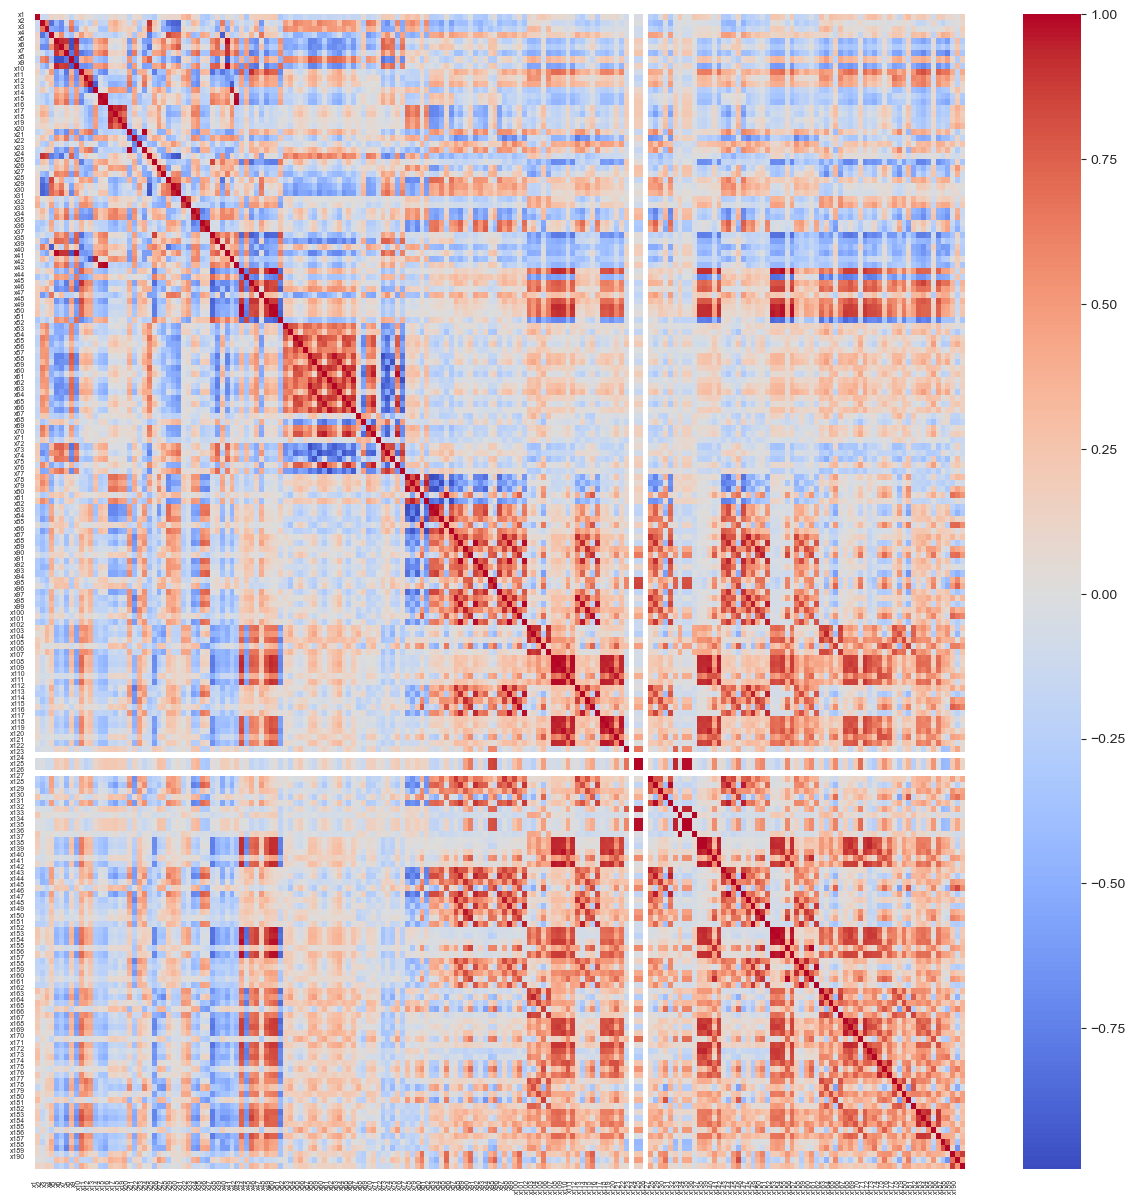

In [30]:
# Run to see how correlated the features are with each other

corrmap = data_df.corr()

plt.subplots(figsize=(15,15))
sns.heatmap(corrmap,center=0, annot=False, cmap="coolwarm", cbar=True) #linewidths=0.5
plt.xticks(range(len(x_labels)),x_labels, fontsize=5, rotation=90)
plt.yticks(range(len(x_labels)),x_labels, fontsize=5)
plt.show()

# Threshold Analysis

## Train / Test split

Training Set: ['R1_2', 'R1_5', 'R1_6', 'R1_8', 'R1_10', 'R1_11', 'R1_12', 'R1_14', 'R1_20', 'R1_21', 'R1_22', 'R1_30', 'R1_32', 'R1_44', 'R1_53', 'R1_64', 'R1_65', 'R1_68', 'R1_70', 'R1_79', 'R1_82', 'R1_88', 'R1_89', 'R1_90', 'R1_103', 'R1_104', 'R1_117', 'R1_133', 'R1_137', 'R1_157', 'R1_158', 'R1_159', 'R1_162', 'R1_163', 'R1_165', 'R1_168', 'R1_169', 'R1_170', 'R1_171', 'R1_175', 'R1_176', 'R1_179', 'R1_180', 'R1_182', 'R1_184', 'R1_185', 'R1_186', 'R1_187', 'R1_196', 'R1_208', 'R1_233', 'R1_239', 'R1_243', 'R1_249', 'R1_251', 'R1_252', 'R1_260', 'R1_266', 'R1_276', 'R1_277', 'R1_280', 'R1_281', 'R1_292', 'R1_295', 'R1_296', 'R1_299', 'R1_303', 'R1_309', 'R1_310', 'R1_311', 'R1_314', 'R1_320', 'R1_323', 'R1_327', 'R1_337', 'R1_340', 'R1_344', 'R1_487', 'R1_566', 'R1_584', 'R1_608', 'R1_720', 'R1_735', 'R1_739', 'R1_795', 'R1_796', 'R1_797', 'R1_798', 'R1_799', 'R1_838', 'R2_2', 'R2_5', 'R2_6', 'R2_8', 'R2_10', 'R2_11', 'R2_12', 'R2_14', 'R2_20', 'R2_21', 'R2_22', 'R2_30', 'R2_32', 

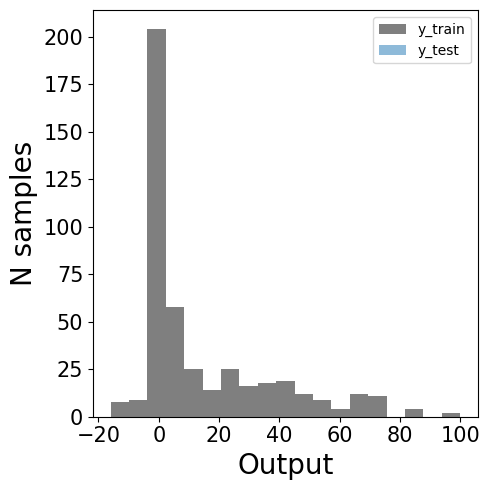

In [3]:
# Split options are 'random', 'ks', 'y_equidist', 'define', 'none'
split = "none"
test_ratio = 0.3 

# New train_test_splits set up returns the data_df index labels for the relevant points
training_set, test_set = hotspot_utils.train_test_splits(data_df, split, test_ratio, x_labels, RESPONSE_LABEL)

## Automatic Threshold Analysis

In [ ]:
# Cutoff in your output for what counts as an active ligand
y_cut = 10

# Set to True if you want points below the y-cut to be considered active
low_is_good = False

# How heavily to value active ligands (1) over inactive ligands (0)
class_weight = {1:10, 0:1} 

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'weighted_accuracy'

# How many threshold dimensions do you want?
n_thresholds = 2

# What percentage of thresholds are analyzed in each subsequent step
percentage = 20

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Set up y_class, the binary list of which y values are above y_cut
hotspot_data_df = copy.deepcopy(data_df)
hotspot_data_df['y_class'] = 0

if(low_is_good):
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] < y_cut)
else:
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] > y_cut)

# Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = hotspot_utils.threshold_generation(hotspot_data_df, class_weight, evaluation_method, x_labelname_dict)
best_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot(hotspot_data_df, [thresh], y_cut, training_set, test_set, evaluation_method, class_weight)
    best_hotspots.append(temp_hs)

# Cut down to the best {percentage} hotspots
best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)

# Add more thresholds, pruning after each step for resource management
for i in range(n_thresholds - 1):
    with Pool(processes=int(n_processors-2)) as p:
        new_hotspots = p.starmap(hotspot_utils.hs_next_thresholds_fast, zip(best_hotspots, repeat(all_thresholds)))
    new_hotspots = [item for sublist in new_hotspots for item in sublist] 
    
    best_hotspots = hotspot_utils.prune_hotspots(new_hotspots, percentage, evaluation_method)

best_hotspots.sort(key = lambda x: x.accuracy_dict[evaluation_method], reverse = True)

# print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:5]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

## Manual Threshold Analysis

In [6]:
# What features do you want in your hotspot?
# For ranges, use data_df.columns[x:y].to_list() to get a list of feature xIDs
# For specific features, use ['xID1', 'xID2', ...]

manual_features = [['x1'], ['x87']]
# manual_features = [['x87']]
# manual_features = [['x1'], ['x87'], x_labels]

# Cutoff for what counts as a hit
y_cut = 10

# How heavily to value hits (1) over misses (0)
class_weight = {1:10, 0:1} 

# What percentage of hotspots to take through to each subsequent step
# Only relevant if using ranges instead of specific parameters
percentage = 100

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'weighted_accuracy'

# Set to True if you want a hotspot of low output results (cold spot?)
low_is_good = False

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Set up y_class, the binary list of which y values are above y_cut
hotspot_data_df = copy.deepcopy(data_df)
hotspot_data_df['y_class'] = 0

if(low_is_good):
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] < y_cut)
else:
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] > y_cut)

# Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = hotspot_utils.threshold_generation(hotspot_data_df, class_weight, evaluation_method, x_labelname_dict, manual_features[0])
best_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot(hotspot_data_df, [thresh], y_cut, training_set, test_set, evaluation_method, class_weight)
    best_hotspots.append(temp_hs)

# Cut down to the best {percentage} hotspots
best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)

# Add more thresholds, pruning after each step for resource management
for i in range(len(manual_features) - 1):
    new_hotspots = []
    for hs in best_hotspots:
        temp_hotspots = hotspot_utils.hs_next_thresholds(hs, hotspot_data_df, class_weight, x_labelname_dict, manual_features[i+1])
        new_hotspots.extend(temp_hotspots)
    best_hotspots = new_hotspots
    del (new_hotspots)
    best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)
    
best_hotspots.sort(key = lambda x: x.accuracy_dict[evaluation_method], reverse = True)
# print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:5]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

Hotspot Index: 0
Total weighted_accuracy with 2 thresholds: 0.922
Initial weighted_accuracy with no thresholds: 0.847
Total accuracy with 2 thresholds: 0.813
Initial accuracy with no thresholds: 0.356
Thresholds: 
	x1 vmin_vmin_boltz < -0.046 with Added weighted_accuracy of 0.025
	x87 vbur_vbur_min < 57.277 with Added weighted_accuracy of 0.051

                    all    train    test
         Accuracy: 0.813   0.813   0.000
Weighted Accuracy: 0.922   0.922   0.000
               F1: 0.785   0.785   0.000
      Weighted F1: 0.954   0.954   0.000

        Precision: 0.665
           Recall: 0.956

**********************************



# Data preparation: Training/Test set split, Scaling

## Optional preparations

In [7]:
# perform transformations on y
y_orig = y.copy() # this is a backup of y

#toggle these options to manipulate y

#exp
# y = np.exp(y_orig)

#log-transformation: either remove all samples with y=0 () or add a small amount to y to avoid log(0).
#y = np.log(y+0.0001)
#or
#y = np.log(y[y.nonzero()[0]])
# y_labels_orig,X_orig = y_labels.copy(),X.copy()
# y_labels = y_labels[y.nonzero()[0]]
# X = X[y.nonzero()[0]]

#absolute value
# y = abs(y)

In [42]:
# preselection option 1
# comment-out first line in Train/test split if using this

# remove samples based on a feature-value 
select_feature = "x8" 

# define cutoff 
mask_prop = X[:,X_labels.index(select_feature)]<5.62   

X_sel,y_sel,y_labels_sel = X[mask_prop],y[mask_prop],y_labels[mask_prop]
print("Shape X: {}".format(X_sel.shape))
print("Shape y: {}".format(y_sel.shape)) 
print("Shape labels: {}".format(y_labels_sel.shape)) 

Shape X: (71, 41)
Shape y: (71,)
Shape labels: (71,)


In [461]:
# preselection
# comment-out first line in Train/test split if using this

# remove samples based on index (0-indexed)

exclude = [38] #+[i for i in range(26,37)]
print(exclude)
mask = [i for i in range(len(y)) if i not in exclude]
X_sel,y_sel,y_labels_sel = X[mask],y[mask],y_labels[mask]

[38]


## Training/Test set split

TS: [1, 3, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20]
VS: [0, 2, 4, 7, 11, 15]
y_mean TS: 4.467
y_mean VS: 4.167
Shape X_train: (15, 2)
Shape X_test:  (6, 2)


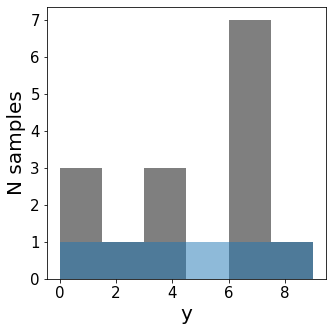

In [159]:
# comment this line out if preselection was performed
X_sel,y_sel,labels_sel,exclude = X,y,y_labels,[]

# select method of split:
# random
# y_equidist - picks points that evenly span the output variable y. 
#              Normally doesn't pick highest/lowest values but this can be activated by changing the variable no_extrapolation in the respective section
# ks - Kennard Stone algorithm picks points based on an even distriution in feature space
# define - give a list of sample indices for either VS or TS in the corresponding code section 
# none - all samples in TS

# the numbers in the variables VS and TS refer to the original 0-indexed sample numbers 

split = "y_equidist"
test_ratio = 0.3 

if split == "random":
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y_sel, random_state=randomstate+3, test_size=test_ratio)    
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]
    
elif split == "define":
   # numbers according to sample lines in the excel sheet (that is, including indexes of 'excluded' samples)
    # for defining the TS, change the names of TS and VS in the next three lines
    #TS = [16,27,25,5,13,9,29,7]
    TS = []
    VS = [16,27,25,5,13,9,29,7]
    #TS = [i-1 for i in VS] # this can be commented out if 0-indexed numbers were defined above
    #VS = [i for i in range(X.shape[0]) if i not in VS and i not in exclude]
    TS = [i for i in range(X.syhape[0]) if i not in VS and i not in exclude]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
elif split == "ks":
    import kennardstonealgorithm as ks
    TS,VS = ks.kennardstonealgorithm(X_sel,int((1-test_ratio)*np.shape(X_sel)[0]))
    X_train, y_train,X_test, y_test = X_sel[TS], y_sel[TS],X_sel[VS], y_sel[VS]
  
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]   

elif split == "y_equidist":
    no_extrapolation = True
    
    import kennardstonealgorithm as ks
    if no_extrapolation:
        minmax = [np.argmin(y_sel),np.argmax(y_sel)]
        y_ks = np.array(([i for i in y_sel if i not in [np.min(y_sel),np.max(y_sel)]]))
        y_ks_indices = [i for i in range(len(y_sel)) if i not in minmax]
        
        # indices relative to y_ks:
        VS_ks,TS_ks = ks.kennardstonealgorithm(y_ks.reshape(np.shape(y_ks)[0],1),int((test_ratio)*(2+np.shape(y_ks)[0])))
        # indices relative to y_sel:
        TS_ = sorted([y_ks_indices[i] for i in list(TS_ks)]+minmax)
        VS_ = sorted([y_ks_indices[i] for i in VS_ks])

    else:
        VS_,TS_ = ks.kennardstonealgorithm(y_sel.reshape(np.shape(y_sel)[0],1),int((test_ratio)*np.shape(y_sel)[0]))
    
    X_train, y_train,X_test, y_test = X_sel[TS_], y_sel[TS_],X_sel[VS_], y_sel[VS_]
    
    # indices relative to y
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]

elif split == "none":
    TS, VS = [i for i in range(X.shape[0]) if i not in exclude],[]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
else: 
    raise ValueError("split option not recognized")
     

print("TS: {}".format(TS))
print("VS: {}".format(VS))
print("y_mean TS: {:.3f}".format(np.mean(y_train)))
print("y_mean VS: {:.3f}".format(np.mean(y_test)))
print("Shape X_train: {}".format(X_train.shape))
print("Shape X_test:  {}".format(X_test.shape))   
plt.figure(figsize=(5, 5))
hist,bins = np.histogram(y_sel,bins="auto")#"auto"
plt.hist(y_train, bins, alpha=0.5, label='y_train',color="black")
plt.hist(y_test, bins, alpha=0.5, label='y_test')
# plt.legend(loc='best')
plt.xlabel("y",fontsize=20)
plt.ylabel("N samples",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Feature Scaling 

In [160]:
# scale features by mean/variance, pick the relevant option (normally: StandardScaler)

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_all_sc = scaler.transform(X_all)

## Cross-terms/Interaction terms

In [71]:
# Add polynomial features/interaction terms
# this is not yet implemented properly in some sections. 
# for 5.1-manual selection: specify cross-term with space between the components: x1 x40 + x6
# Essentially only section 5.2 can use cross-terms so far
# don't run this twice

polyfeats = PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
X_train_p = polyfeats.fit_transform(X_train_sc)  #[:,[1,8,0]])
X_test_p = polyfeats.transform(X_test_sc)
X_all_p = polyfeats.transform(X_all_sc)

def add_to_x(matchobj):
    if "^" in matchobj.group(0):
        n = int(matchobj.group(0).split("^")[0])+1
        return("{} x{}".format(n,n))
    else:
        return(str(int(matchobj.group(0))+1))
    
pfnames = np.asarray([re.sub("[0-9]+(\^[0-9])*",add_to_x,st) for st in polyfeats.get_feature_names()])



In [72]:
# filter out non-significant crossterms based on p-value with target variable
p_val_cutoff = 0.005

r2s = []
pvals = []
for f_ind,feature in enumerate(X_train_p.T):
    slope, intercept, r_value, p_value, std_err = stats.linregress(feature, y_train)    
    r2s.append(r_value**2)
    pvals.append(p_value)
    
r2s_ = np.asarray(r2s)
pvals_ = np.asarray(pvals)

keep_p_ = [i[0] for i in np.argwhere(pvals_<p_val_cutoff) if i not in range(np.shape(X_all)[1])]
keep_p = [i for i in range(np.shape(X_all)[1])] + keep_p_

def sub_label_to_name(matchobj):
    return(X_labelname_dict[matchobj.group(0)])
def sub_labelname(matchobj):
    return(matchobj.group(0)+" "+X_labelname_dict[matchobj.group(0)])
    
pfnames = np.asarray([re.sub("[0-9]+(\^[0-9])*",add_to_x,st) for st in polyfeats.get_feature_names()])
X_p_labels = list(np.reshape(pfnames[keep_p],len(keep_p)))
X_p_names = [re.sub("x[0-9]+",sub_label_to_name,st) for st in X_p_labels]
X_p_labelname = [re.sub("x[0-9]+",sub_labelname,st) for st in X_p_labels]

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train_p[:,keep_p])
X_test_sc = scaler.transform(X_test_p[:,keep_p])
X_all_sc = scaler.transform(X_all_p[:,keep_p])

X_labels = X_p_labels
X_names = X_p_names
X_labelname = X_p_labelname

print("{} cross-terms with p-value < {}".format(len(keep_p_),p_val_cutoff))

2749 cross-terms with p-value < 0.005


# Linear modelling, feature selection

## Manual selection of features


Split method: y_equidist
Test ratio: 0.3

Features: x49 + x73

Parameters:
   26.0196 + 
  -10.0351 * x49 nbo_N_oxamide_max
    2.5798 * x73 nbo_aryl_sub_=O_max_max

Training R2  = 0.847
Training Q2  = 0.724
Training MAE = 4.113
Training K-fold R2 = 0.691 (+/- 0.011)

Test R2      = 0.719
Test MAE     = 5.656


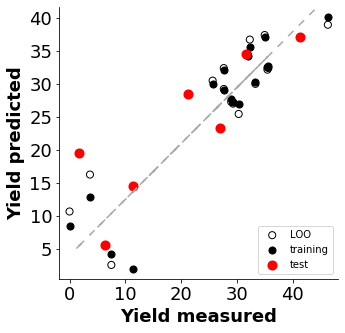

In [6]:
#provide an x__ model (string, any order of terms)
features_x =  "x49 +x73"#
features_py = sorted([X_labels.index(i.strip()) for i in features_x.split("+")])

# features_py = []
#features = sorted([int(i[1:]) for i in re.findall("x\d+",features_x)])
#features_py = [i-1 for i in features]


X_train_sel = X_train_sc[:,features_py]
X_test_sel = X_test_sc[:,features_py]
#lr = Ridge(alpha=1E-5).fit(X_train_sel, y_train)

lr = LinearRegression().fit(X_train_sel, y_train)
alphas = np.logspace(-6,3,10)

#for i in alphas:
#lr = Ridge(alpha=i).fit(X_train_sel, y_train)     
#print(f'\nalpha: {i}')
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores = repeated_k_fold(X_train_sel,y_train,k=5,n=200)

print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(features_py)[i]]) for i in range(len(features_py))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores.mean(), kfoldscores.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))

# settings for plot and saving
#plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav="plotname",label="$ΔΔG^{≠}$",loo_pred=loo_train)
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="Yield",loo_pred=loo_train)
    

model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
#print(model.summary())

In [75]:
# add all individual features to the manual model
add_df = pd.DataFrame(index=X_labelname,columns=["label_sep","label_abs","Training R2","Training Q2"],dtype=float)

update_model = False
for f_ind in range(len(X_labels)):
    features_iter = features_py + [f_ind]    
    X_train_sel = X_train_sc[:,features_iter]
    X_test_sel = X_test_sc[:,features_iter]
    # lr = Ridge(alpha=1E-1).fit(X_train_sel, y_train)
    lr = LinearRegression().fit(X_train_sel, y_train)
    q2,loo_train = loo.q2(X_train_sel,y_train,lr)
    add_df.iloc[f_ind,:] = [X_labels[f_ind],"x"+str(f_ind+1),lr.score(X_train_sel, y_train),q2]

if update_model and X_labelname.index(add_df['Training Q2'].idxmax()) not in features_py:
    features_py.append(X_labelname.index(add_df['Training Q2'].idxmax()))
add_df.sort_values(by=['Training Q2'],ascending=False).head(20)

,label_sep,label_abs,Training R2,Training Q2
x162 sterimol_NC_B1_boltz,x162,x162,0.938486,0.909798
x160 sterimol_NC_B1_min,x160,x160,0.934844,0.908756
x114 dist_OtoH_min_boltz,x114,x114,0.936990,0.907152
x118 dist_OtoH_max_boltz,x118,x118,0.933595,0.900620
x103 nbo_orthoup_minE,x103,x103,0.928722,0.896669
x109 nbo_orthodown_max,x109,x109,0.934867,0.896568
x106 nbo_orthoup_boltz,x106,x106,0.928586,0.896445
x104 nbo_orthoup_min,x104,x104,0.927600,0.894793
x105 nbo_orthoup_max,x105,x105,0.926833,0.893567
x74 nbo_aryl_sub_=O_max_boltz,x74,x74,0.929512,0.892903


In [76]:
# remove each individual feature from the manual model
print("\n"+" + ".join(["x"+str(i+1) for i in sorted(features_py)]))

rem_df = pd.DataFrame(index=[X_labelname[i] for i in features_py],
                      columns=["Training R2","Training Q2"])
for f_ind in features_py:
    features_iter = [i for i in features_py if i != f_ind]
#     print(feature, x_names[f_ind])
    X_train_sel = X_train_sc[:,features_iter]
    X_test_sel = X_test_sc[:,features_iter]
    # lr = Ridge(alpha=1E-1).fit(X_train_sel, y_train)
    lr = LinearRegression().fit(X_train_sel, y_train)
    q2,loo_train = loo.q2(X_train_sel,y_train,lr)
    rem_df.loc[X_labelname[f_ind],:] = [lr.score(X_train_sel, y_train),q2]

rem_df.sort_values(by=['Training Q2'],ascending=False)


x1 + x49 + x73


,Training R2,Training Q2
x73 nbo_aryl_sub_=O_max_max,0.854655,0.811655
x49 nbo_N_oxamide_max,0.836137,0.801408
x1 is_sub2,0.119686,-0.14503


## Forward stepwise selection based on p-values

Add                               0 with p-value 8.84865e-10
killed
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     87.01
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           8.85e-10
Time:                        14:26:41   Log-Likelihood:                -94.813
No. Observations:                  28   AIC:                             193.6
Df Residuals:                      26   BIC:                             196.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

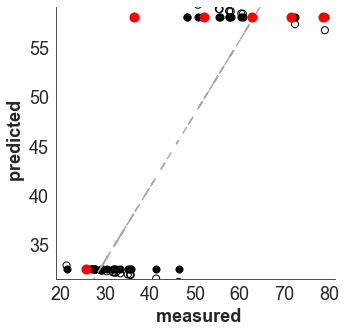

In [105]:
# Forward stepwise selection based on p-value
# threshold values refer to p-value of individual features
threshold_in = 0.05
threshold_out = 0.075 # must be larger than threshold_in

use_manual_feats = False # if True, model from previous section will be used as starting point

import stepwise_selection2 as step_s
if not use_manual_feats:
    features_py=[]

features_py = step_s.stepwise_selection(pd.DataFrame(X_train_sc), y_train,
                    initial_list=features_py,threshold_in=threshold_in,threshold_out=threshold_out,verbose=True)

print("\n"+" + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\n"+" + ".join([X_labelname[i] for i in sorted(features_py)]))

X_train_sel = X_train_sc[:,features_py]
X_test_sel = X_test_sc[:,features_py]
#lr = RidgeCV(alphas=np.logspace(-6,3,10), cv=3).fit(X_train_sel, y_train) 
print(f'\nalpha: {lr.alpha_}')
lr = LinearRegression().fit(X_train_sel, y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100,reg=LinearRegression())

print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(features_py)[i]]) for i in range(len(features_py))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")


testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu)) 
    
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="",loo_pred=loo_train)


## other forward feature selection implementations


Split method: y_equidist
Test ratio: 0.2

x1 + x2 + x7 + x129

is_sub2 + is_sub4 + homo_Ehomo_minE + ir_OH_int_max
Training R2;Training Q2;Test R2;0.83;0.77;0.45

yikes. that's ass.


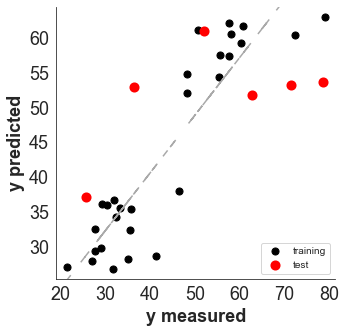

In [144]:
#Scikit-learn - forward feature selection
# largely useless
# options for criteria: 
# mutual_info_regression, f_regression
# select number of features with k
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

criteria = f_regression
skb = SelectKBest(criteria,k=4).fit(X_train_sc,y_train)
selected_feats = skb.get_support(indices=True)
print(" + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\n"+" + ".join([X_names[i] for i in sorted(selected_feats)]))

X_train_sel = skb.transform(X_train_sc)
X_test_sel = skb.transform(X_test_sc)
lr = LinearRegression().fit(X_train_sel, y_train)
q2,loo_train = loo.q2(X_train_sel,y_train)

y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test)

# uncomment to add model to candidate list
# keepmodels.append(features_py)

Time taken for 1856 iterations (minutes): 0.33
Score = 145.40, Number Selected = 9
model formula: y ~ x1 + x103 + x73 + x152 + x42 + x105 + x176 + x33 + x168 
Time taken for Final Model (minutes): 0.33
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     90.17
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           4.04e-13
Time:                        14:27:56   Log-Likelihood:                -61.758
No. Observations:                  28   AIC:                             143.5
Df Residuals:                      18   BIC:                             156.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
        

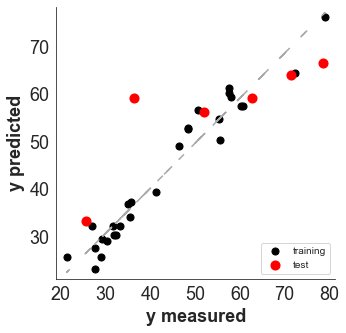

In [107]:
# Forward stepwise selection based on AIC ("aic") or Q2 ("q2")
criteria = "aic"
#criteria = "q2"

import forwardselect_q5 as fsq

df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))

newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
a,b = fsq.Forward_Select(df,"y","Regression",criteria)
selected_feats = [int(i[1:]) for i in b]

print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print(" + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\n"+" + ".join([X_names[i] for i in sorted(selected_feats)]))

X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
lr = LinearRegression().fit(X_train_sel, y_train)
q2,loo_train = loo.q2(X_train_sel,y_train)
print("\n\n")
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test)

# uncomment to add model to candidate list
# keepmodels.append(features_py)

## Forward stepwise selection keeping a set of candidates at each step

### Model search

Step 1
Step 2
Finished 1 and 2 parameter models. Time taken (sec): 9.3252
Step 3
cutpar:  1
cutpar:  1
cutpar:  1
Done. Time taken (minutes): 0.33

Split method: y_equidist
Test ratio: 0.2


Best model:
1 + x1 + x103 + x73
1 + homo_mu_minE + is_sub4 + nbo_C_CObyNH_min

Features: x1 + x73 + x103

Parameters:
   43.5476 + 
   12.9154 * x1 is_sub2
    3.6231 * x73 nbo_aryl_sub_=O_max_max
   -4.5059 * x103 nbo_orthoup_minE

Training R2  = 0.928
Training Q2  = 0.897
Training MAE = 3.033
Training K-fold R2 = 0.119 (+/- 3.481)

Test R2      = 0.796
Test MAE     = 8.651


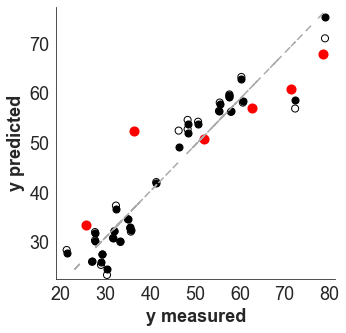

In [111]:
# Forward stepwise selection keeping a set of candidates at each step
n_steps = 3
n_candidates = 20
collin_criteria = 0.5 # this is R2
skipfeatures = [] #["x4","x3"]

import ForwardStepCandidates_2 as fsc
df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))
newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
df.drop(skipfeatures,axis=1,inplace=True)

results,models,scores,sortedmodels,candidates = fsc.ForwardStep_py(df,'y',
                    n_steps=n_steps,n_candidates=n_candidates,collin_criteria=collin_criteria)
model_sel = results.loc[0,"Model"]
selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]

print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print("\nBest model:")
print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[candidates[0]].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)

### View models as list

In [82]:
# view best models
results.sort_values(by=['Q^2'],ascending=False).head(50)

,Model,n_terms,R^2,Q^2
0,"(x1, x103, x73)",3,0.928046,0.896676
1,"(x103, x2, x73)",3,0.928046,0.896676
2,"(x106, x2, x73)",3,0.927953,0.896558
3,"(x1, x106, x73)",3,0.927953,0.896558
4,"(x162, x2, x73)",3,0.926606,0.894750
5,"(x1, x162, x73)",3,0.926606,0.894750
6,"(x1, x104, x73)",3,0.926652,0.894596
7,"(x104, x2, x73)",3,0.926652,0.894596
9,"(x160, x2, x73)",3,0.924596,0.893709
8,"(x1, x160, x73)",3,0.924596,0.893709


### Filter results

In [83]:
# view models with a specific number of terms
selmods = results[results.n_terms <=2].sort_values(by=['Q^2'],ascending=False)
selmods.head(50)

,Model,n_terms,R^2,Q^2
482,"(x1, x103)",2,0.869155,0.833062
484,"(x103, x2)",2,0.869155,0.833062
483,"(x2, x103)",2,0.869155,0.833062
485,"(x1, x106)",2,0.869099,0.833017
487,"(x106, x2)",2,0.869099,0.833017
486,"(x2, x106)",2,0.869099,0.833017
518,"(x1, x104)",2,0.867661,0.830987
520,"(x104, x2)",2,0.867661,0.830987
519,"(x2, x104)",2,0.867661,0.830987
558,"(x1, x105)",2,0.865730,0.828479


In [84]:
# example for filtering results
#filter to find models containing specified parameters

l1 = [*range(138, 163, 1)] 
l2 = []
for i in l1:
    a = "x{}".format(i)
    l2.append(a)

selmods2 = results.loc[[i for i in results.index if any(x in l2 for x in results.loc[i,'Model']) and "x200" not in results.loc[i,"Model"]]].sort_values(by=['Q^2'],ascending=False)

selmods2.head(25)

,Model,n_terms,R^2,Q^2
4,"(x162, x2, x73)",3,0.926606,0.894750
5,"(x1, x162, x73)",3,0.926606,0.894750
8,"(x1, x160, x73)",3,0.924596,0.893709
9,"(x160, x2, x73)",3,0.924596,0.893709
12,"(x1, x162, x77)",3,0.921244,0.890399
13,"(x162, x2, x77)",3,0.921244,0.890399
18,"(x160, x2, x77)",3,0.919210,0.888605
19,"(x1, x160, x77)",3,0.919210,0.888605
24,"(x1, x160, x42)",3,0.910189,0.876479
25,"(x160, x2, x42)",3,0.910189,0.876479


In [85]:
# example for filtering results

selmods2 = results.loc[[i for i in results.index if "x113" in results.loc[i,"Model"] and "x49" not in results.loc[i,"Model"]]][results.n_terms < 5].sort_values(by=['Q^2'],ascending=False)
selmods2

,Model,n_terms,R^2,Q^2
268,"(x106, x113, x2)",3,0.883243,0.841903
269,"(x1, x106, x113)",3,0.883243,0.841903
270,"(x103, x113, x2)",3,0.882902,0.841347
271,"(x1, x103, x113)",3,0.882902,0.841347
282,"(x1, x104, x113)",3,0.882221,0.840736
283,"(x104, x113, x2)",3,0.882221,0.840736
378,"(x1, x105, x113)",3,0.880483,0.837822
379,"(x105, x113, x2)",3,0.880483,0.837822
892,"(x1, x113)",2,0.776213,0.723167
893,"(x2, x113)",2,0.776213,0.723167


In [ ]:
# filter models that contain more than one term that is also in a reference model
reference_model = 0 # this number refer to the index in 'results' or 'selmods', whichever is used 
use_df = results # or: selmods

uniquemods = {use_df.loc[reference_model,"Model"]:reference_model}
for ind in use_df.index:
    selmod = use_df.loc[ind,"Model"]
    if len(selmod) <= 2:
        continue
        
    add = True
    for mod in uniquemods.keys():
        if len([i for i in mod if i in selmod]) >= 2:
            add = False
            break
    if add:      
        uniquemods[use_df.loc[ind,"Model"]] = ind
    
    
print(len(uniquemods.keys()))
selmods2 = results.loc[uniquemods.values()]
selmods2

### Visualize models

Split method: y_equidist
Test ratio: 0.2

1 + x1 + x162 + x77
1 + is_sub2 + sterimol_NC_B1_boltz + nbo_aryl_sub_=O_avg_max

Features: x1 + x77 + x162

Parameters:
   43.5476 + 
   12.9809 * x1 is_sub2
    4.9069 * x77 nbo_aryl_sub_=O_avg_max
    5.1789 * x162 sterimol_NC_B1_boltz

Training R2  = 0.921
Training Q2  = 0.890
Training MAE = 3.302
Training K-fold R2 = 0.879 (+/- 0.001)

Test R2      = 0.690
Test MAE     = 10.301


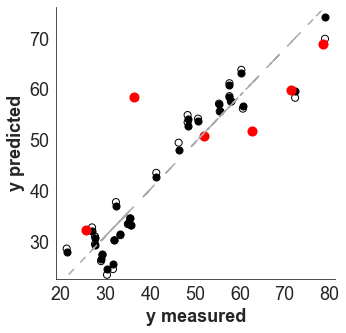

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     93.58
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           2.21e-13
Time:                        14:30:19   Log-Likelihood:                -79.805
No. Observations:                  28   AIC:                             167.6
Df Residuals:                      24   BIC:                             172.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.5476      0.854     50.991      0.0

In [113]:
# visualize other models
model_sel = results.loc[12,"Model"]

#other ways of selecting models:
# model_sel = results.iloc[selmods.index[3],0]
# model_sel = results.iloc[785,0]
# model_sel = ("x100","x31")


selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]

print("Split method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[model_sel].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)



print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")


testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
trainr2 = lr.score(X_train_sel, y_train)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insu))
    
plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
print(model.summary())

1 + x1 + x103
1 + is_sub2 + nbo_orthoup_minE

____________________________________________________________________________________
1 + x103 + x2
1 + nbo_orthoup_minE + is_sub4

____________________________________________________________________________________
1 + x2 + x103
1 + is_sub4 + nbo_orthoup_minE

____________________________________________________________________________________
1 + x1 + x106
1 + is_sub2 + nbo_orthoup_boltz

____________________________________________________________________________________
1 + x106 + x2
1 + nbo_orthoup_boltz + is_sub4

____________________________________________________________________________________
1 + x2 + x106
1 + is_sub4 + nbo_orthoup_boltz

____________________________________________________________________________________
1 + x1 + x104
1 + is_sub2 + nbo_orthoup_min

____________________________________________________________________________________
1 + x104 + x2
1 + nbo_orthoup_min + is_sub4

____________________________________

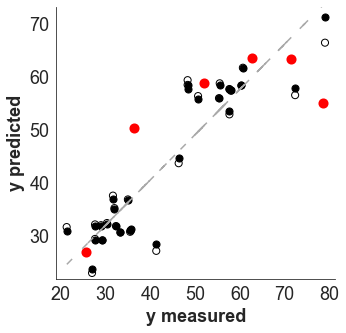

____________________________________________________________________________________
1 + x1 + x49
1 + is_sub2 + nbo_N_oxamide_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x49

Parameters:
   43.5476 + 
   13.1751 * x1 is_sub2
   -4.3407 * x49 nbo_N_oxamide_max

Training R2  = 0.855
Training Q2  = 0.812
Training MAE = 4.205
Training K-fold R2 = 0.802 (+/- 0.001)

Test R2      = 0.691
Test MAE     = 9.125


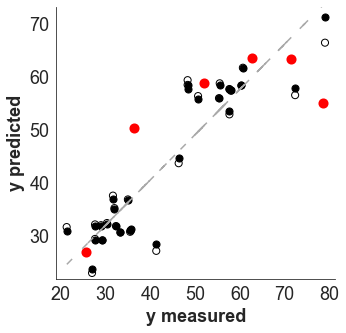

____________________________________________________________________________________
1 + x2 + x50
1 + is_sub4 + nbo_N_oxamide_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x50

Parameters:
   43.5476 + 
  -12.8992 * x2 is_sub4
   -4.3554 * x50 nbo_N_oxamide_boltz

Training R2  = 0.855
Training Q2  = 0.810
Training MAE = 4.513
Training K-fold R2 = 0.805 (+/- 0.000)

Test R2      = 0.744
Test MAE     = 9.445


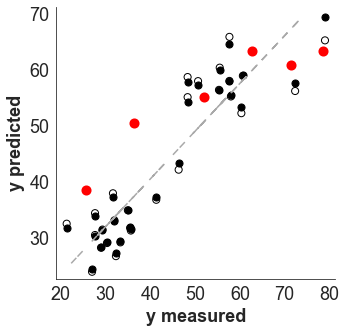

____________________________________________________________________________________
1 + x1 + x50
1 + is_sub2 + nbo_N_oxamide_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x50

Parameters:
   43.5476 + 
   12.8992 * x1 is_sub2
   -4.3554 * x50 nbo_N_oxamide_boltz

Training R2  = 0.855
Training Q2  = 0.810
Training MAE = 4.513
Training K-fold R2 = 0.808 (+/- 0.000)

Test R2      = 0.744
Test MAE     = 9.445


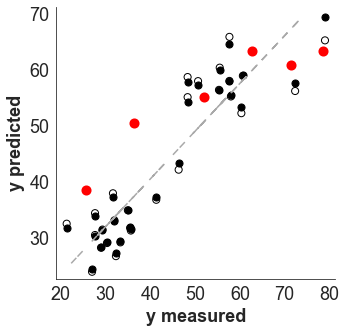

____________________________________________________________________________________
1 + x2 + x73
1 + is_sub4 + nbo_aryl_sub_=O_max_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x73

Parameters:
   43.5476 + 
  -13.0995 * x2 is_sub4
    3.8644 * x73 nbo_aryl_sub_=O_max_max

Training R2  = 0.837
Training Q2  = 0.801
Training MAE = 4.185
Training K-fold R2 = 0.794 (+/- 0.000)

Test R2      = 0.794
Test MAE     = 8.234


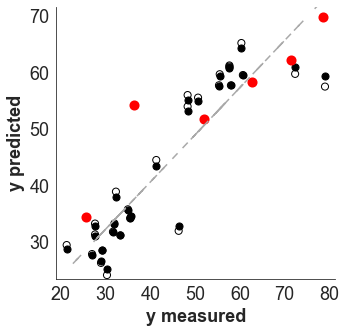

____________________________________________________________________________________
1 + x1 + x73
1 + is_sub2 + nbo_aryl_sub_=O_max_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x73

Parameters:
   43.5476 + 
   13.0995 * x1 is_sub2
    3.8644 * x73 nbo_aryl_sub_=O_max_max

Training R2  = 0.837
Training Q2  = 0.801
Training MAE = 4.185
Training K-fold R2 = 0.794 (+/- 0.000)

Test R2      = 0.794
Test MAE     = 8.234


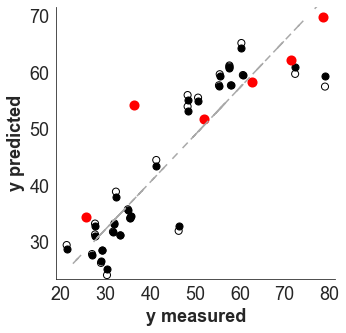

____________________________________________________________________________________
1 + x1 + x98
1 + is_sub2 + nbo_C_CObyNH_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x98

Parameters:
   43.5476 + 
   13.3045 * x1 is_sub2
    3.9774 * x98 nbo_C_CObyNH_boltz

Training R2  = 0.841
Training Q2  = 0.789
Training MAE = 4.104
Training K-fold R2 = 0.772 (+/- 0.002)

Test R2      = 0.672
Test MAE     = 9.639


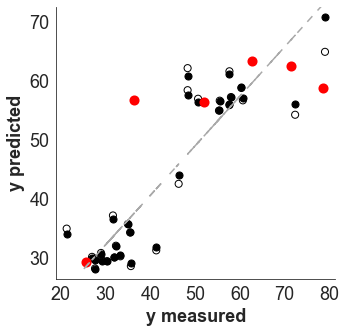

____________________________________________________________________________________
1 + x2 + x98
1 + is_sub4 + nbo_C_CObyNH_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x98

Parameters:
   43.5476 + 
  -13.3045 * x2 is_sub4
    3.9774 * x98 nbo_C_CObyNH_boltz

Training R2  = 0.841
Training Q2  = 0.789
Training MAE = 4.104
Training K-fold R2 = 0.765 (+/- 0.002)

Test R2      = 0.672
Test MAE     = 9.639


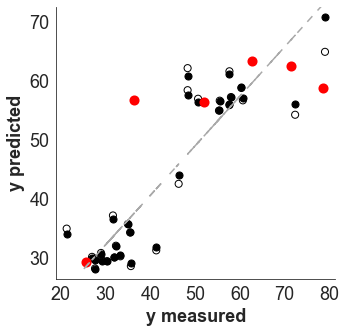

____________________________________________________________________________________
1 + x2 + x47
1 + is_sub4 + nbo_N_oxamide_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x47

Parameters:
   43.5476 + 
  -13.2105 * x2 is_sub4
   -3.8421 * x47 nbo_N_oxamide_minE

Training R2  = 0.836
Training Q2  = 0.778
Training MAE = 4.700
Training K-fold R2 = 0.772 (+/- 0.001)

Test R2      = 0.685
Test MAE     = 10.606


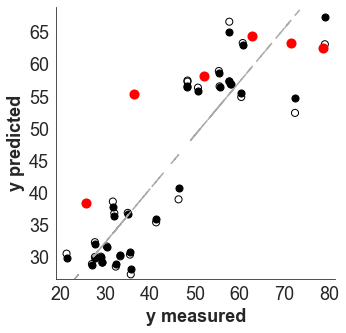

____________________________________________________________________________________
1 + x1 + x47
1 + is_sub2 + nbo_N_oxamide_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x47

Parameters:
   43.5476 + 
   13.2105 * x1 is_sub2
   -3.8421 * x47 nbo_N_oxamide_minE

Training R2  = 0.836
Training Q2  = 0.778
Training MAE = 4.700
Training K-fold R2 = 0.771 (+/- 0.001)

Test R2      = 0.685
Test MAE     = 10.606


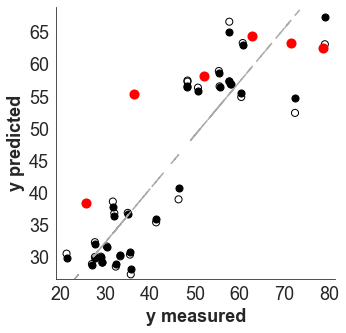

____________________________________________________________________________________
1 + x2 + x77
1 + is_sub4 + nbo_aryl_sub_=O_avg_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x77

Parameters:
   43.5476 + 
  -13.2326 * x2 is_sub4
    3.1606 * x77 nbo_aryl_sub_=O_avg_max

Training R2  = 0.815
Training Q2  = 0.777
Training MAE = 4.365
Training K-fold R2 = 0.771 (+/- 0.000)

Test R2      = 0.772
Test MAE     = 8.558


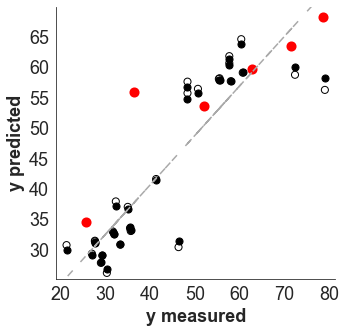

____________________________________________________________________________________
1 + x1 + x77
1 + is_sub2 + nbo_aryl_sub_=O_avg_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x77

Parameters:
   43.5476 + 
   13.2326 * x1 is_sub2
    3.1606 * x77 nbo_aryl_sub_=O_avg_max

Training R2  = 0.815
Training Q2  = 0.777
Training MAE = 4.365
Training K-fold R2 = 0.768 (+/- 0.000)

Test R2      = 0.772
Test MAE     = 8.558


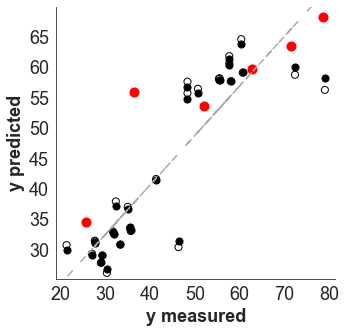

____________________________________________________________________________________
1 + x1 + x101
1 + is_sub2 + nbo_C_ipso_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x101

Parameters:
   43.5476 + 
   12.9231 * x1 is_sub2
    3.8953 * x101 nbo_C_ipso_max

Training R2  = 0.838
Training Q2  = 0.773
Training MAE = 4.342
Training K-fold R2 = 0.759 (+/- 0.001)

Test R2      = 0.754
Test MAE     = 9.523


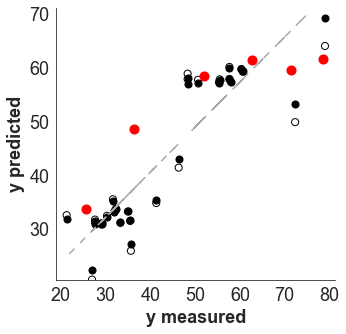

____________________________________________________________________________________
1 + x2 + x101
1 + is_sub4 + nbo_C_ipso_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x101

Parameters:
   43.5476 + 
  -12.9231 * x2 is_sub4
    3.8953 * x101 nbo_C_ipso_max

Training R2  = 0.838
Training Q2  = 0.773
Training MAE = 4.342
Training K-fold R2 = 0.761 (+/- 0.002)

Test R2      = 0.754
Test MAE     = 9.523


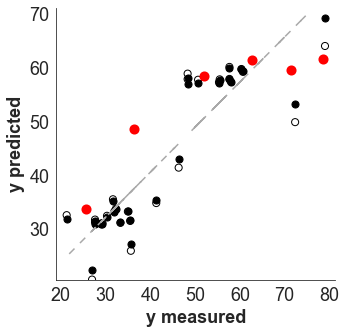

____________________________________________________________________________________
1 + x101 + x2
1 + nbo_C_ipso_max + is_sub4


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x101

Parameters:
   43.5476 + 
  -12.9231 * x2 is_sub4
    3.8953 * x101 nbo_C_ipso_max

Training R2  = 0.838
Training Q2  = 0.773
Training MAE = 4.342
Training K-fold R2 = 0.763 (+/- 0.001)

Test R2      = 0.754
Test MAE     = 9.523


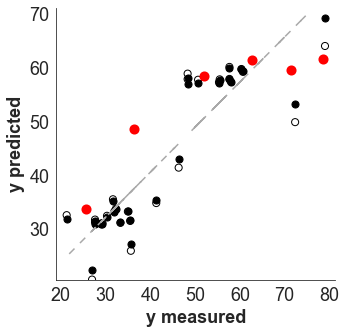

____________________________________________________________________________________
1 + x129 + x2
1 + ir_OH_int_max + is_sub4

____________________________________________________________________________________
1 + x2 + x129
1 + is_sub4 + ir_OH_int_max

____________________________________________________________________________________
1 + x1 + x129
1 + is_sub2 + ir_OH_int_max

____________________________________________________________________________________
1 + x1 + x96
1 + is_sub2 + nbo_C_CObyNH_min


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x96

Parameters:
   43.5476 + 
   13.2270 * x1 is_sub2
    3.5763 * x96 nbo_C_CObyNH_min

Training R2  = 0.827
Training Q2  = 0.771
Training MAE = 4.964
Training K-fold R2 = 0.767 (+/- 0.001)

Test R2      = 0.762
Test MAE     = 9.133


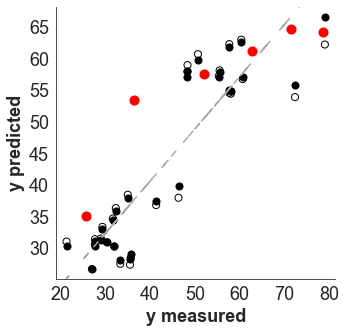

____________________________________________________________________________________
1 + x2 + x96
1 + is_sub4 + nbo_C_CObyNH_min


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x96

Parameters:
   43.5476 + 
  -13.2270 * x2 is_sub4
    3.5763 * x96 nbo_C_CObyNH_min

Training R2  = 0.827
Training Q2  = 0.771
Training MAE = 4.964
Training K-fold R2 = 0.764 (+/- 0.001)

Test R2      = 0.762
Test MAE     = 9.133


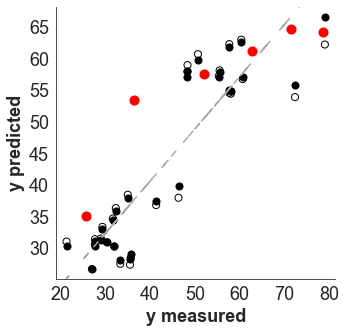

____________________________________________________________________________________
1 + x1 + x144
1 + is_sub2 + ir_CO_byNH_int_min

____________________________________________________________________________________
1 + x2 + x144
1 + is_sub4 + ir_CO_byNH_int_min

____________________________________________________________________________________
1 + x144 + x2
1 + ir_CO_byNH_int_min + is_sub4

____________________________________________________________________________________
1 + x1 + x146
1 + is_sub2 + ir_CO_byNH_int_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x146

Parameters:
   43.5476 + 
   13.5952 * x1 is_sub2
   -3.6071 * x146 ir_CO_byNH_int_boltz

Training R2  = 0.827
Training Q2  = 0.767
Training MAE = 4.587
Training K-fold R2 = 0.761 (+/- 0.001)

Test R2      = 0.745
Test MAE     = 8.849


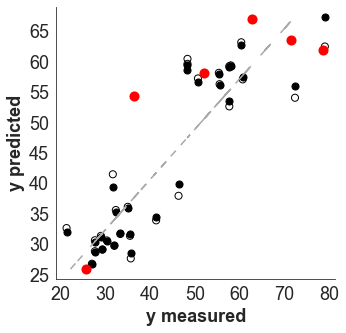

____________________________________________________________________________________
1 + x2 + x146
1 + is_sub4 + ir_CO_byNH_int_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x146

Parameters:
   43.5476 + 
  -13.5952 * x2 is_sub4
   -3.6071 * x146 ir_CO_byNH_int_boltz

Training R2  = 0.827
Training Q2  = 0.767
Training MAE = 4.587
Training K-fold R2 = 0.760 (+/- 0.001)

Test R2      = 0.745
Test MAE     = 8.849


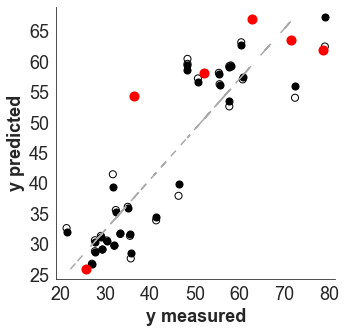

____________________________________________________________________________________
1 + x146 + x2
1 + ir_CO_byNH_int_boltz + is_sub4


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x146

Parameters:
   43.5476 + 
  -13.5952 * x2 is_sub4
   -3.6071 * x146 ir_CO_byNH_int_boltz

Training R2  = 0.827
Training Q2  = 0.767
Training MAE = 4.587
Training K-fold R2 = 0.761 (+/- 0.001)

Test R2      = 0.745
Test MAE     = 8.849


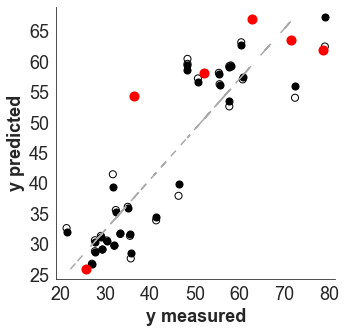

____________________________________________________________________________________
1 + x2 + x16
1 + is_sub4 + homo_mu_min

____________________________________________________________________________________
1 + x16 + x2
1 + homo_mu_min + is_sub4

____________________________________________________________________________________
1 + x1 + x16
1 + is_sub2 + homo_mu_min

____________________________________________________________________________________
1 + x2 + x61
1 + is_sub4 + nbo_O_CObyOH_max

____________________________________________________________________________________
1 + x1 + x61
1 + is_sub2 + nbo_O_CObyOH_max

____________________________________________________________________________________
1 + x162 + x2
1 + sterimol_NC_B1_boltz + is_sub4

____________________________________________________________________________________
1 + x1 + x162
1 + is_sub2 + sterimol_NC_B1_boltz

____________________________________________________________________________________
1 + x2 + x

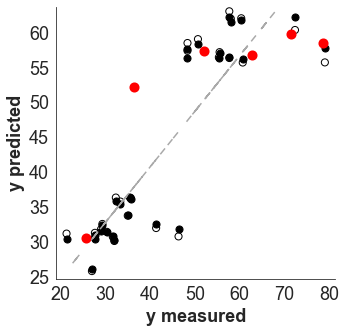

____________________________________________________________________________________
1 + x2 + x39
1 + is_sub4 + qpole_yy_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x39

Parameters:
   43.5476 + 
  -12.8814 * x2 is_sub4
    2.5445 * x39 qpole_yy_minE

Training R2  = 0.799
Training Q2  = 0.756
Training MAE = 4.656
Training K-fold R2 = 0.749 (+/- 0.000)

Test R2      = 0.690
Test MAE     = 10.571


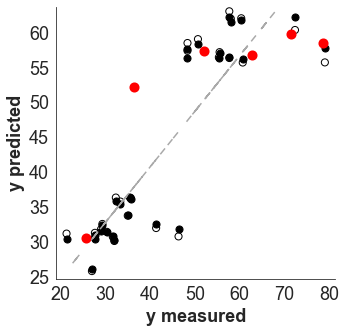

____________________________________________________________________________________
1 + x2 + x166
1 + is_sub4 + sterimol_NC_B5_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x166

Parameters:
   43.5476 + 
  -13.4691 * x2 is_sub4
   -2.6197 * x166 sterimol_NC_B5_boltz

Training R2  = 0.800
Training Q2  = 0.756
Training MAE = 4.774
Training K-fold R2 = 0.749 (+/- 0.001)

Test R2      = 0.697
Test MAE     = 10.102


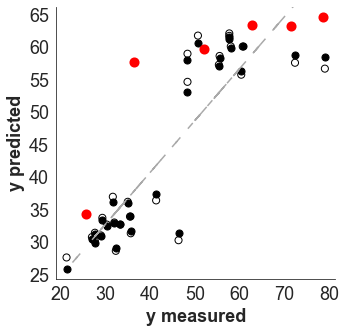

____________________________________________________________________________________
1 + x166 + x2
1 + sterimol_NC_B5_boltz + is_sub4


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x166

Parameters:
   43.5476 + 
  -13.4691 * x2 is_sub4
   -2.6197 * x166 sterimol_NC_B5_boltz

Training R2  = 0.800
Training Q2  = 0.756
Training MAE = 4.774
Training K-fold R2 = 0.745 (+/- 0.001)

Test R2      = 0.697
Test MAE     = 10.102


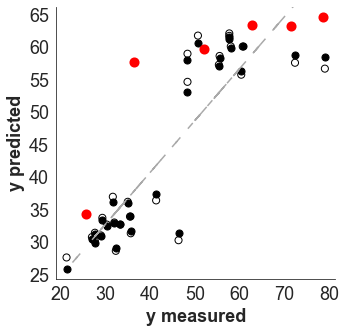

____________________________________________________________________________________
1 + x1 + x166
1 + is_sub2 + sterimol_NC_B5_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x166

Parameters:
   43.5476 + 
   13.4691 * x1 is_sub2
   -2.6197 * x166 sterimol_NC_B5_boltz

Training R2  = 0.800
Training Q2  = 0.756
Training MAE = 4.774
Training K-fold R2 = 0.749 (+/- 0.000)

Test R2      = 0.697
Test MAE     = 10.102


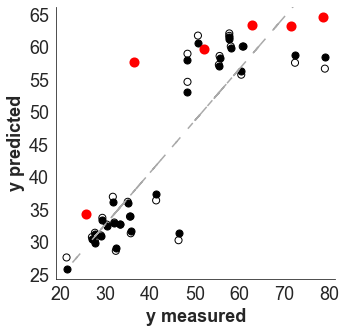

____________________________________________________________________________________
1 + x2 + x15
1 + is_sub4 + homo_mu_minE

____________________________________________________________________________________
1 + x15 + x2
1 + homo_mu_minE + is_sub4

____________________________________________________________________________________
1 + x1 + x15
1 + is_sub2 + homo_mu_minE

____________________________________________________________________________________
1 + x2 + x99
1 + is_sub4 + nbo_C_ipso_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x99

Parameters:
   43.5476 + 
  -12.9144 * x2 is_sub4
    3.5083 * x99 nbo_C_ipso_minE

Training R2  = 0.825
Training Q2  = 0.755
Training MAE = 4.607
Training K-fold R2 = 0.715 (+/- 0.015)

Test R2      = 0.737
Test MAE     = 9.773


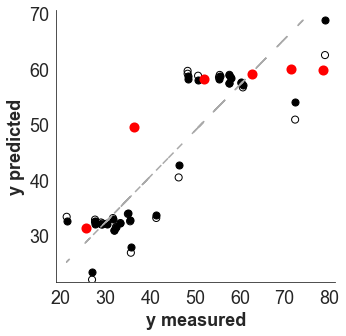

____________________________________________________________________________________
1 + x1 + x99
1 + is_sub2 + nbo_C_ipso_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x99

Parameters:
   43.5476 + 
   12.9144 * x1 is_sub2
    3.5083 * x99 nbo_C_ipso_minE

Training R2  = 0.825
Training Q2  = 0.755
Training MAE = 4.607
Training K-fold R2 = 0.738 (+/- 0.004)

Test R2      = 0.737
Test MAE     = 9.773


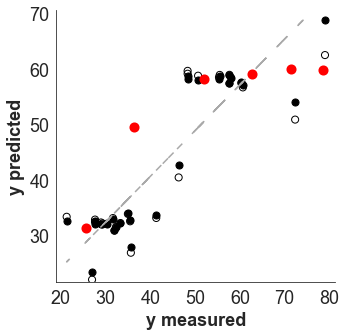

____________________________________________________________________________________
1 + x1 + x65
1 + is_sub2 + nbo_O_CObyNH_max

____________________________________________________________________________________
1 + x2 + x65
1 + is_sub4 + nbo_O_CObyNH_max

____________________________________________________________________________________
1 + x1 + x19
1 + is_sub2 + homo_eta_minE

____________________________________________________________________________________
1 + x2 + x19
1 + is_sub4 + homo_eta_minE

____________________________________________________________________________________
1 + x2 + x10
1 + is_sub4 + homo_Ehomo_boltz

____________________________________________________________________________________
1 + x1 + x10
1 + is_sub2 + homo_Ehomo_boltz

____________________________________________________________________________________
1 + x1 + x42
1 + is_sub2 + qpole_yy_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x42

Parameters:
   43.5476 + 
   12.923

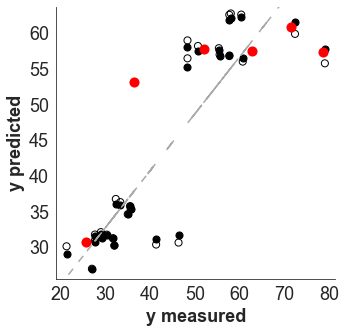

____________________________________________________________________________________
1 + x2 + x42
1 + is_sub4 + qpole_yy_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x42

Parameters:
   43.5476 + 
  -12.9237 * x2 is_sub4
    2.4853 * x42 qpole_yy_boltz

Training R2  = 0.798
Training Q2  = 0.754
Training MAE = 4.612
Training K-fold R2 = 0.751 (+/- 0.000)

Test R2      = 0.667
Test MAE     = 10.810


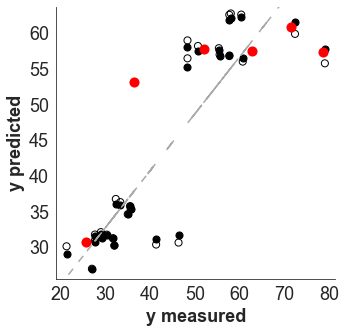

____________________________________________________________________________________
1 + x1 + x18
1 + is_sub2 + homo_mu_boltz

____________________________________________________________________________________
1 + x2 + x18
1 + is_sub4 + homo_mu_boltz

____________________________________________________________________________________
1 + x2 + x149
1 + is_sub4 + ir_NH_freq_max

____________________________________________________________________________________
1 + x1 + x149
1 + is_sub2 + ir_NH_freq_max

____________________________________________________________________________________
1 + x2 + x67
1 + is_sub4 + nbo_aryl_sub_=O_min_minE

____________________________________________________________________________________
1 + x1 + x67
1 + is_sub2 + nbo_aryl_sub_=O_min_minE

____________________________________________________________________________________
1 + x1 + x17
1 + is_sub2 + homo_mu_max

____________________________________________________________________________________
1 

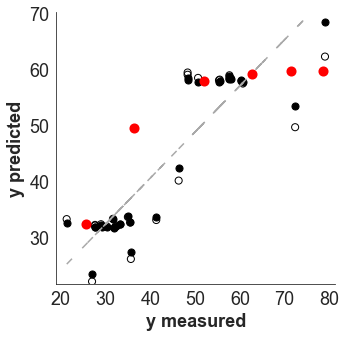

____________________________________________________________________________________
1 + x1 + x102
1 + is_sub2 + nbo_C_ipso_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x102

Parameters:
   43.5476 + 
   12.8710 * x1 is_sub2
    3.4794 * x102 nbo_C_ipso_boltz

Training R2  = 0.824
Training Q2  = 0.749
Training MAE = 4.499
Training K-fold R2 = 0.719 (+/- 0.006)

Test R2      = 0.730
Test MAE     = 9.951


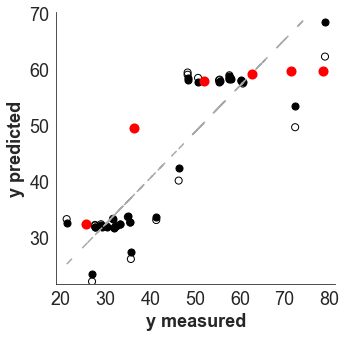

____________________________________________________________________________________
1 + x1 + x173
1 + is_sub2 + sterimol_CS_B1_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x173

Parameters:
   43.5476 + 
   13.4696 * x1 is_sub2
   -2.2299 * x173 sterimol_CS_B1_max

Training R2  = 0.792
Training Q2  = 0.748
Training MAE = 4.774
Training K-fold R2 = 0.743 (+/- 0.000)

Test R2      = 0.689
Test MAE     = 10.047


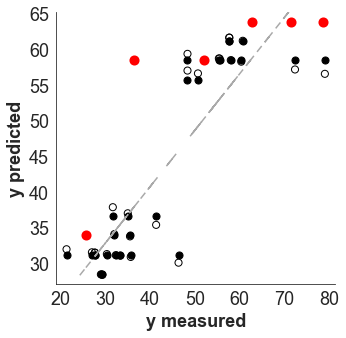

____________________________________________________________________________________
1 + x2 + x173
1 + is_sub4 + sterimol_CS_B1_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x173

Parameters:
   43.5476 + 
  -13.4696 * x2 is_sub4
   -2.2299 * x173 sterimol_CS_B1_max

Training R2  = 0.792
Training Q2  = 0.748
Training MAE = 4.774
Training K-fold R2 = 0.742 (+/- 0.000)

Test R2      = 0.689
Test MAE     = 10.047


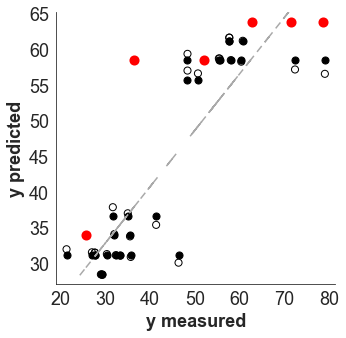

____________________________________________________________________________________
1 + x173 + x2
1 + sterimol_CS_B1_max + is_sub4


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x173

Parameters:
   43.5476 + 
  -13.4696 * x2 is_sub4
   -2.2299 * x173 sterimol_CS_B1_max

Training R2  = 0.792
Training Q2  = 0.748
Training MAE = 4.774
Training K-fold R2 = 0.742 (+/- 0.000)

Test R2      = 0.689
Test MAE     = 10.047


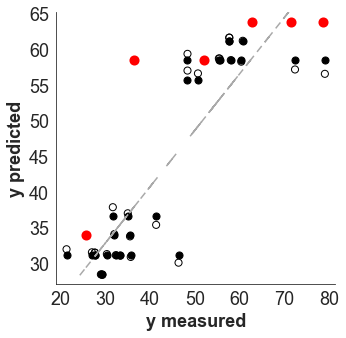

____________________________________________________________________________________
1 + x1 + x141
1 + is_sub2 + ir_CO_byNH_freq_max

____________________________________________________________________________________
1 + x2 + x141
1 + is_sub4 + ir_CO_byNH_freq_max

____________________________________________________________________________________
1 + x2 + x143
1 + is_sub4 + ir_CO_byNH_int_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x143

Parameters:
   43.5476 + 
  -13.2428 * x2 is_sub4
   -2.9961 * x143 ir_CO_byNH_int_minE

Training R2  = 0.810
Training Q2  = 0.747
Training MAE = 4.942
Training K-fold R2 = 0.742 (+/- 0.001)

Test R2      = 0.729
Test MAE     = 8.824


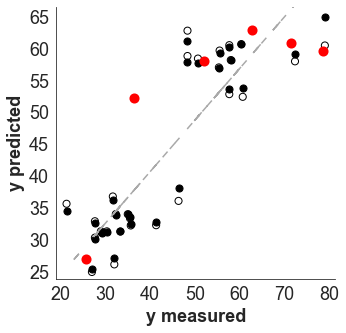

____________________________________________________________________________________
1 + x1 + x143
1 + is_sub2 + ir_CO_byNH_int_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x143

Parameters:
   43.5476 + 
   13.2428 * x1 is_sub2
   -2.9961 * x143 ir_CO_byNH_int_minE

Training R2  = 0.810
Training Q2  = 0.747
Training MAE = 4.942
Training K-fold R2 = 0.741 (+/- 0.001)

Test R2      = 0.729
Test MAE     = 8.824


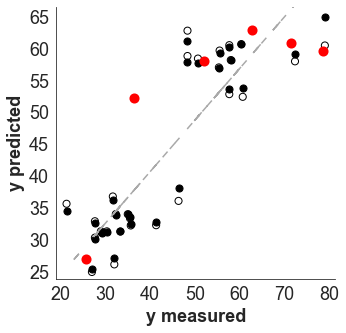

____________________________________________________________________________________
1 + x2 + x137
1 + is_sub4 + ir_CO_byOH_int_max

____________________________________________________________________________________
1 + x1 + x137
1 + is_sub2 + ir_CO_byOH_int_max

____________________________________________________________________________________
1 + x2 + x78
1 + is_sub4 + nbo_aryl_sub_=O_avg_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x78

Parameters:
   43.5476 + 
  -13.1979 * x2 is_sub4
    2.0886 * x78 nbo_aryl_sub_=O_avg_boltz

Training R2  = 0.789
Training Q2  = 0.744
Training MAE = 4.741
Training K-fold R2 = 0.740 (+/- 0.000)

Test R2      = 0.669
Test MAE     = 10.096


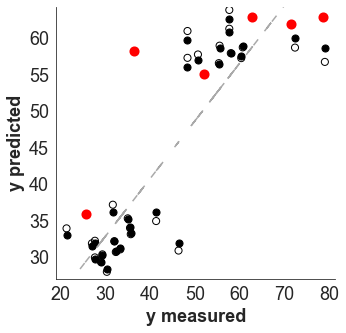

____________________________________________________________________________________
1 + x1 + x78
1 + is_sub2 + nbo_aryl_sub_=O_avg_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x78

Parameters:
   43.5476 + 
   13.1979 * x1 is_sub2
    2.0886 * x78 nbo_aryl_sub_=O_avg_boltz

Training R2  = 0.789
Training Q2  = 0.744
Training MAE = 4.741
Training K-fold R2 = 0.739 (+/- 0.000)

Test R2      = 0.669
Test MAE     = 10.096


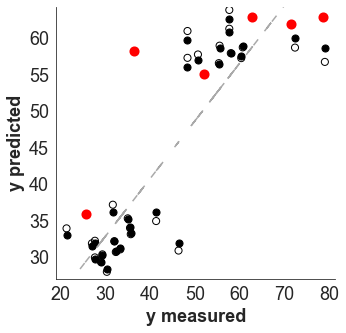

____________________________________________________________________________________
1 + x1 + x69
1 + is_sub2 + nbo_aryl_sub_=O_min_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x69

Parameters:
   43.5476 + 
   13.2803 * x1 is_sub2
    2.0573 * x69 nbo_aryl_sub_=O_min_max

Training R2  = 0.789
Training Q2  = 0.744
Training MAE = 4.641
Training K-fold R2 = 0.735 (+/- 0.000)

Test R2      = 0.713
Test MAE     = 9.727


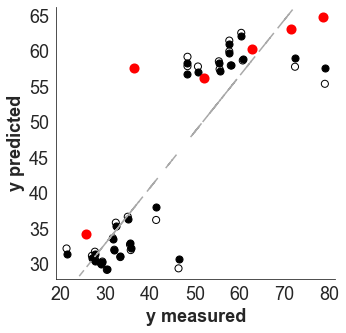

____________________________________________________________________________________
1 + x2 + x69
1 + is_sub4 + nbo_aryl_sub_=O_min_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x69

Parameters:
   43.5476 + 
  -13.2803 * x2 is_sub4
    2.0573 * x69 nbo_aryl_sub_=O_min_max

Training R2  = 0.789
Training Q2  = 0.744
Training MAE = 4.641
Training K-fold R2 = 0.740 (+/- 0.000)

Test R2      = 0.713
Test MAE     = 9.727


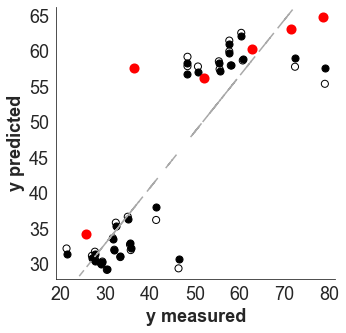

____________________________________________________________________________________
1 + x2 + x75
1 + is_sub4 + nbo_aryl_sub_=O_avg_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x75

Parameters:
   43.5476 + 
  -13.2201 * x2 is_sub4
    2.0650 * x75 nbo_aryl_sub_=O_avg_minE

Training R2  = 0.789
Training Q2  = 0.743
Training MAE = 4.756
Training K-fold R2 = 0.736 (+/- 0.000)

Test R2      = 0.661
Test MAE     = 10.224


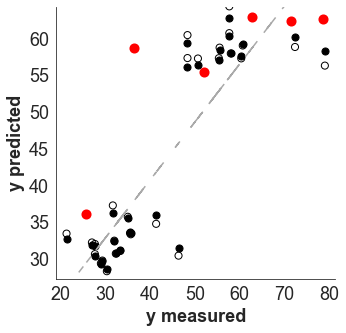

____________________________________________________________________________________
1 + x1 + x75
1 + is_sub2 + nbo_aryl_sub_=O_avg_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x75

Parameters:
   43.5476 + 
   13.2201 * x1 is_sub2
    2.0650 * x75 nbo_aryl_sub_=O_avg_minE

Training R2  = 0.789
Training Q2  = 0.743
Training MAE = 4.756
Training K-fold R2 = 0.739 (+/- 0.000)

Test R2      = 0.661
Test MAE     = 10.224


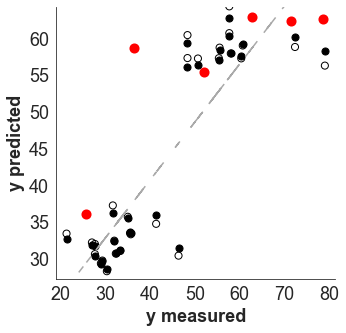

____________________________________________________________________________________
1 + x1 + x81
1 + is_sub2 + NBO_aryl_sub_min_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x81

Parameters:
   43.5476 + 
   13.4051 * x1 is_sub2
   -2.0966 * x81 NBO_aryl_sub_min_max

Training R2  = 0.789
Training Q2  = 0.742
Training MAE = 5.047
Training K-fold R2 = 0.733 (+/- 0.001)

Test R2      = 0.721
Test MAE     = 9.839


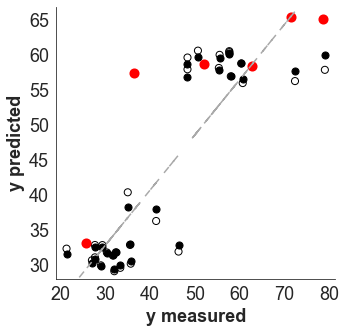

____________________________________________________________________________________
1 + x1 + x85
1 + is_sub2 + NBO_aryl_sub_max_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x85

Parameters:
   43.5476 + 
   13.4051 * x1 is_sub2
   -2.0966 * x85 NBO_aryl_sub_max_max

Training R2  = 0.789
Training Q2  = 0.742
Training MAE = 5.047
Training K-fold R2 = 0.741 (+/- 0.000)

Test R2      = 0.721
Test MAE     = 9.839


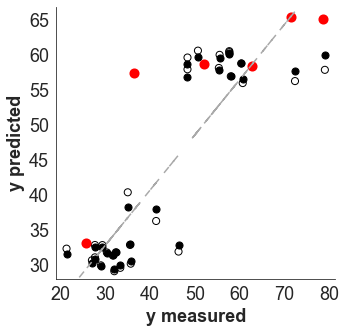

____________________________________________________________________________________
1 + x1 + x89
1 + is_sub2 + NBO_aryl_sub_avg_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x89

Parameters:
   43.5476 + 
   13.4051 * x1 is_sub2
   -2.0966 * x89 NBO_aryl_sub_avg_max

Training R2  = 0.789
Training Q2  = 0.742
Training MAE = 5.047
Training K-fold R2 = 0.736 (+/- 0.000)

Test R2      = 0.721
Test MAE     = 9.839


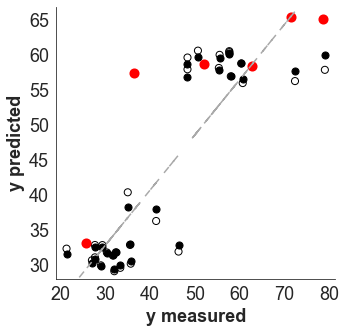

____________________________________________________________________________________
1 + x2 + x81
1 + is_sub4 + NBO_aryl_sub_min_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x81

Parameters:
   43.5476 + 
  -13.4051 * x2 is_sub4
   -2.0966 * x81 NBO_aryl_sub_min_max

Training R2  = 0.789
Training Q2  = 0.742
Training MAE = 5.047
Training K-fold R2 = 0.737 (+/- 0.000)

Test R2      = 0.721
Test MAE     = 9.839


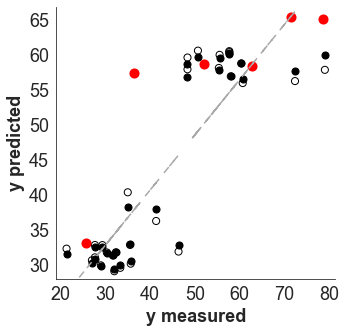

____________________________________________________________________________________
1 + x2 + x85
1 + is_sub4 + NBO_aryl_sub_max_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x85

Parameters:
   43.5476 + 
  -13.4051 * x2 is_sub4
   -2.0966 * x85 NBO_aryl_sub_max_max

Training R2  = 0.789
Training Q2  = 0.742
Training MAE = 5.047
Training K-fold R2 = 0.734 (+/- 0.000)

Test R2      = 0.721
Test MAE     = 9.839


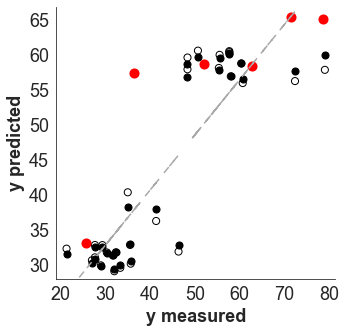

____________________________________________________________________________________
1 + x2 + x89
1 + is_sub4 + NBO_aryl_sub_avg_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x89

Parameters:
   43.5476 + 
  -13.4051 * x2 is_sub4
   -2.0966 * x89 NBO_aryl_sub_avg_max

Training R2  = 0.789
Training Q2  = 0.742
Training MAE = 5.047
Training K-fold R2 = 0.734 (+/- 0.000)

Test R2      = 0.721
Test MAE     = 9.839


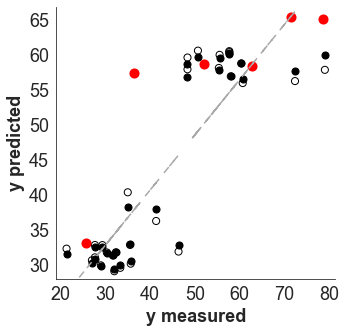

____________________________________________________________________________________
1 + x2 + x185
1 + is_sub4 + sterimol_SN_B1_max

____________________________________________________________________________________
1 + x1 + x185
1 + is_sub2 + sterimol_SN_B1_max

____________________________________________________________________________________
1 + x2 + x55
1 + is_sub4 + nbo_O_OH_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x55

Parameters:
   43.5476 + 
  -13.6141 * x2 is_sub4
   -2.8618 * x55 nbo_O_OH_minE

Training R2  = 0.805
Training Q2  = 0.741
Training MAE = 5.021
Training K-fold R2 = 0.734 (+/- 0.001)

Test R2      = 0.733
Test MAE     = 8.846


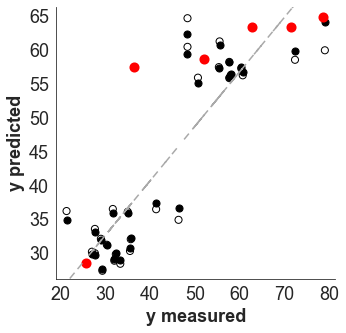

____________________________________________________________________________________
1 + x1 + x55
1 + is_sub2 + nbo_O_OH_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x55

Parameters:
   43.5476 + 
   13.6141 * x1 is_sub2
   -2.8618 * x55 nbo_O_OH_minE

Training R2  = 0.805
Training Q2  = 0.741
Training MAE = 5.021
Training K-fold R2 = 0.731 (+/- 0.001)

Test R2      = 0.733
Test MAE     = 8.846


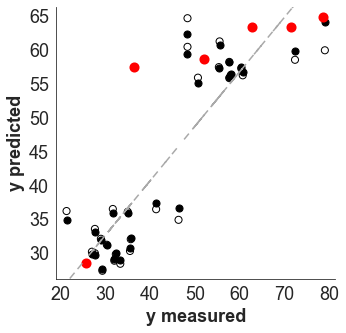

____________________________________________________________________________________
1 + x2 + x6
1 + is_sub4 + dipole_boltz

____________________________________________________________________________________
1 + x1 + x6
1 + is_sub2 + dipole_boltz

____________________________________________________________________________________
1 + x2 + x100
1 + is_sub4 + nbo_C_ipso_min


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x100

Parameters:
   43.5476 + 
  -12.6786 * x2 is_sub4
    3.3633 * x100 nbo_C_ipso_min

Training R2  = 0.820
Training Q2  = 0.740
Training MAE = 4.584
Training K-fold R2 = 0.717 (+/- 0.003)

Test R2      = 0.692
Test MAE     = 10.777


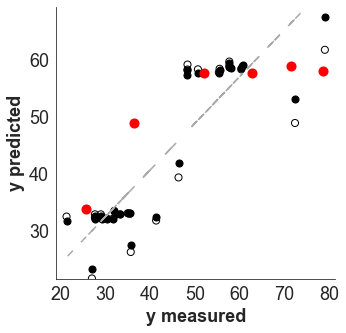

____________________________________________________________________________________
1 + x1 + x100
1 + is_sub2 + nbo_C_ipso_min


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x100

Parameters:
   43.5476 + 
   12.6786 * x1 is_sub2
    3.3633 * x100 nbo_C_ipso_min

Training R2  = 0.820
Training Q2  = 0.740
Training MAE = 4.584
Training K-fold R2 = 0.718 (+/- 0.004)

Test R2      = 0.692
Test MAE     = 10.777


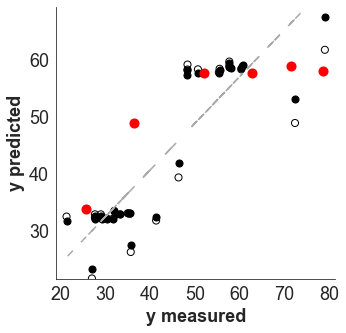

____________________________________________________________________________________
1 + x1 + x118
1 + is_sub2 + dist_OtoH_max_boltz

____________________________________________________________________________________
1 + x2 + x118
1 + is_sub4 + dist_OtoH_max_boltz

____________________________________________________________________________________
1 + x2 + x9
1 + is_sub4 + homo_Ehomo_max

____________________________________________________________________________________
1 + x1 + x9
1 + is_sub2 + homo_Ehomo_max

____________________________________________________________________________________
1 + x1 + x150
1 + is_sub2 + ir_NH_freq_boltz

____________________________________________________________________________________
1 + x2 + x150
1 + is_sub4 + ir_NH_freq_boltz

____________________________________________________________________________________
1 + x2 + x8
1 + is_sub4 + homo_Ehomo_min

____________________________________________________________________________________
1 + 

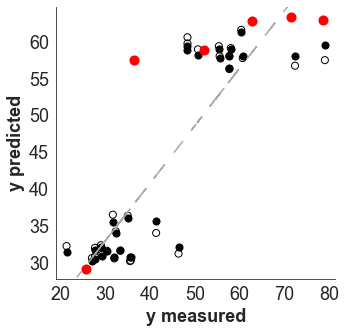

____________________________________________________________________________________
1 + x2 + x138
1 + is_sub4 + ir_CO_byOH_int_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x138

Parameters:
   43.5476 + 
  -13.5258 * x2 is_sub4
   -1.6761 * x138 ir_CO_byOH_int_boltz

Training R2  = 0.782
Training Q2  = 0.736
Training MAE = 5.010
Training K-fold R2 = 0.730 (+/- 0.001)

Test R2      = 0.710
Test MAE     = 9.222


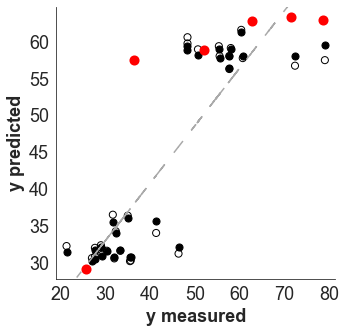

____________________________________________________________________________________
1 + x1 + x148
1 + is_sub2 + ir_NH_freq_min

____________________________________________________________________________________
1 + x2 + x148
1 + is_sub4 + ir_NH_freq_min

____________________________________________________________________________________
1 + x2 + x48
1 + is_sub4 + nbo_N_oxamide_min

____________________________________________________________________________________
1 + x1 + x48
1 + is_sub2 + nbo_N_oxamide_min

____________________________________________________________________________________
1 + x2 + x58
1 + is_sub4 + nbo_O_OH_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x58

Parameters:
   43.5476 + 
  -13.7615 * x2 is_sub4
   -2.4918 * x58 nbo_O_OH_boltz

Training R2  = 0.796
Training Q2  = 0.734
Training MAE = 4.870
Training K-fold R2 = 0.728 (+/- 0.001)

Test R2      = 0.691
Test MAE     = 9.471


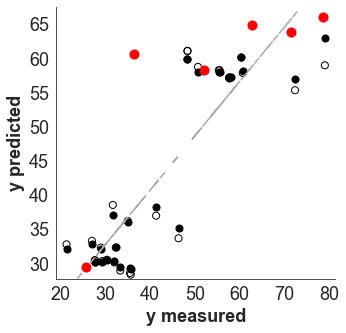

____________________________________________________________________________________
1 + x1 + x58
1 + is_sub2 + nbo_O_OH_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x58

Parameters:
   43.5476 + 
   13.7615 * x1 is_sub2
   -2.4918 * x58 nbo_O_OH_boltz

Training R2  = 0.796
Training Q2  = 0.734
Training MAE = 4.870
Training K-fold R2 = 0.724 (+/- 0.001)

Test R2      = 0.691
Test MAE     = 9.471


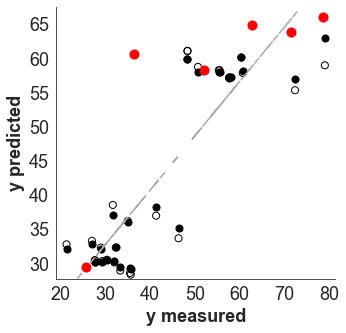

____________________________________________________________________________________
1 + x1 + x135
1 + is_sub2 + ir_CO_byOH_int_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x135

Parameters:
   43.5476 + 
   13.4463 * x1 is_sub2
   -1.8575 * x135 ir_CO_byOH_int_minE

Training R2  = 0.785
Training Q2  = 0.734
Training MAE = 4.971
Training K-fold R2 = 0.724 (+/- 0.001)

Test R2      = 0.716
Test MAE     = 9.222


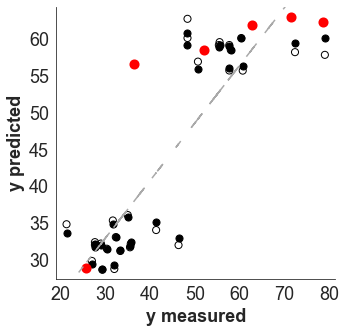

____________________________________________________________________________________
1 + x2 + x135
1 + is_sub4 + ir_CO_byOH_int_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x135

Parameters:
   43.5476 + 
  -13.4463 * x2 is_sub4
   -1.8575 * x135 ir_CO_byOH_int_minE

Training R2  = 0.785
Training Q2  = 0.734
Training MAE = 4.971
Training K-fold R2 = 0.726 (+/- 0.000)

Test R2      = 0.716
Test MAE     = 9.222


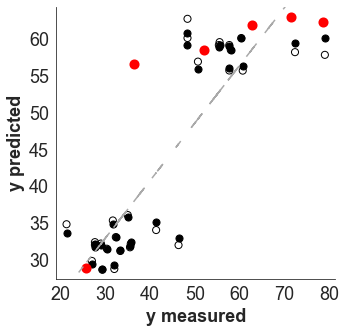

____________________________________________________________________________________
1 + x135 + x2
1 + ir_CO_byOH_int_minE + is_sub4


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x135

Parameters:
   43.5476 + 
  -13.4463 * x2 is_sub4
   -1.8575 * x135 ir_CO_byOH_int_minE

Training R2  = 0.785
Training Q2  = 0.734
Training MAE = 4.971
Training K-fold R2 = 0.727 (+/- 0.001)

Test R2      = 0.716
Test MAE     = 9.222


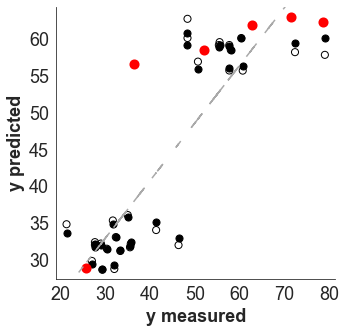

____________________________________________________________________________________
1 + x1 + x92
1 + is_sub2 + nbo_C_CObyOH_min

____________________________________________________________________________________
1 + x2 + x92
1 + is_sub4 + nbo_C_CObyOH_min

____________________________________________________________________________________
1 + x1 + x183
1 + is_sub2 + sterimol_SN_B1_minE

____________________________________________________________________________________
1 + x2 + x183
1 + is_sub4 + sterimol_SN_B1_minE

____________________________________________________________________________________
1 + x2 + x163
1 + is_sub4 + sterimol_NC_B5_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x163

Parameters:
   43.5476 + 
  -13.2671 * x2 is_sub4
   -1.7471 * x163 sterimol_NC_B5_minE

Training R2  = 0.784
Training Q2  = 0.733
Training MAE = 5.110
Training K-fold R2 = 0.727 (+/- 0.000)

Test R2      = 0.696
Test MAE     = 10.316


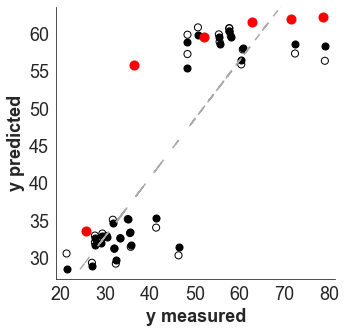

____________________________________________________________________________________
1 + x1 + x163
1 + is_sub2 + sterimol_NC_B5_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x163

Parameters:
   43.5476 + 
   13.2671 * x1 is_sub2
   -1.7471 * x163 sterimol_NC_B5_minE

Training R2  = 0.784
Training Q2  = 0.733
Training MAE = 5.110
Training K-fold R2 = 0.730 (+/- 0.001)

Test R2      = 0.696
Test MAE     = 10.316


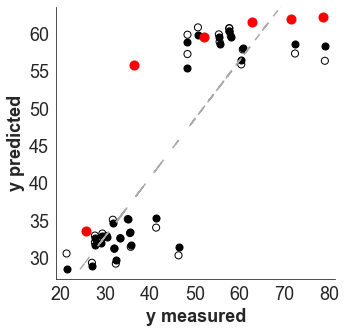

____________________________________________________________________________________
1 + x1 + x131
1 + is_sub2 + ir_CO_byOH_freq_minE

____________________________________________________________________________________
1 + x2 + x131
1 + is_sub4 + ir_CO_byOH_freq_minE

____________________________________________________________________________________
1 + x1 + x134
1 + is_sub2 + ir_CO_byOH_freq_boltz

____________________________________________________________________________________
1 + x2 + x134
1 + is_sub4 + ir_CO_byOH_freq_boltz

____________________________________________________________________________________
1 + x1 + x20
1 + is_sub2 + homo_eta_min

____________________________________________________________________________________
1 + x2 + x20
1 + is_sub4 + homo_eta_min

____________________________________________________________________________________
1 + x1 + x124
1 + is_sub2 + ir_OH_freq_min

_____________________________________________________________________________

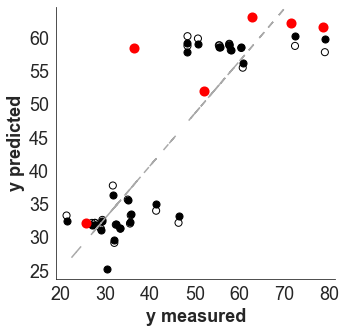

____________________________________________________________________________________
1 + x2 + x72
1 + is_sub4 + nbo_aryl_sub_=O_max_min


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x72

Parameters:
   43.5476 + 
  -13.2016 * x2 is_sub4
    1.9675 * x72 nbo_aryl_sub_=O_max_min

Training R2  = 0.787
Training Q2  = 0.730
Training MAE = 5.172
Training K-fold R2 = 0.725 (+/- 0.000)

Test R2      = 0.678
Test MAE     = 9.217


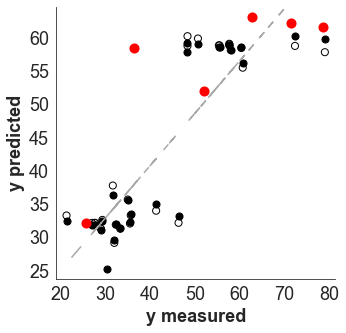

____________________________________________________________________________________
1 + x1 + x35
1 + is_sub2 + qpole_xx_minE

____________________________________________________________________________________
1 + x2 + x35
1 + is_sub4 + qpole_xx_minE

____________________________________________________________________________________
1 + x1 + x172
1 + is_sub2 + sterimol_CS_B1_min

____________________________________________________________________________________
1 + x2 + x172
1 + is_sub4 + sterimol_CS_B1_min

____________________________________________________________________________________
1 + x2 + x62
1 + is_sub4 + nbo_O_CObyOH_boltz

____________________________________________________________________________________
1 + x1 + x62
1 + is_sub2 + nbo_O_CObyOH_boltz

____________________________________________________________________________________
1 + x1 + x46
1 + is_sub2 + qpole_zz_boltz

____________________________________________________________________________________
1 +

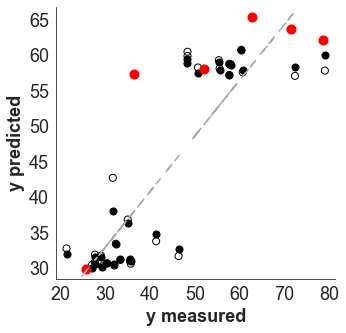

____________________________________________________________________________________
1 + x2 + x130
1 + is_sub4 + ir_OH_int_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x130

Parameters:
   43.5476 + 
  -13.5343 * x2 is_sub4
   -1.8608 * x130 ir_OH_int_boltz

Training R2  = 0.785
Training Q2  = 0.729
Training MAE = 4.933
Training K-fold R2 = 0.719 (+/- 0.001)

Test R2      = 0.703
Test MAE     = 9.676


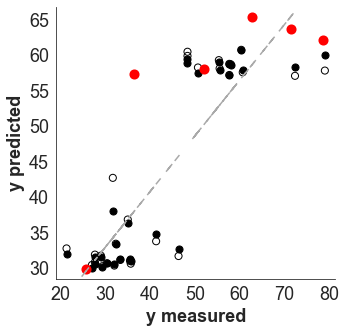

____________________________________________________________________________________
1 + x1 + x51
1 + is_sub2 + nbo_aryl_sub_sub_minE

____________________________________________________________________________________
1 + x2 + x51
1 + is_sub4 + nbo_aryl_sub_sub_minE

____________________________________________________________________________________
1 + x2 + x25
1 + is_sub4 + homo_omega_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x25

Parameters:
   43.5476 + 
  -12.8743 * x2 is_sub4
    1.5448 * x25 homo_omega_max

Training R2  = 0.780
Training Q2  = 0.729
Training MAE = 4.795
Training K-fold R2 = 0.723 (+/- 0.001)

Test R2      = 0.654
Test MAE     = 11.155


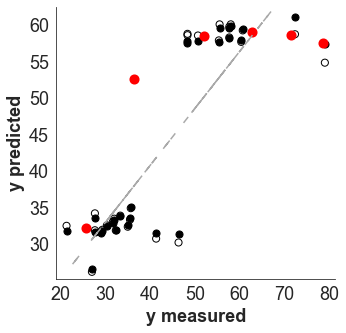

____________________________________________________________________________________
1 + x1 + x25
1 + is_sub2 + homo_omega_max


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x25

Parameters:
   43.5476 + 
   12.8743 * x1 is_sub2
    1.5448 * x25 homo_omega_max

Training R2  = 0.780
Training Q2  = 0.729
Training MAE = 4.795
Training K-fold R2 = 0.718 (+/- 0.000)

Test R2      = 0.654
Test MAE     = 11.155


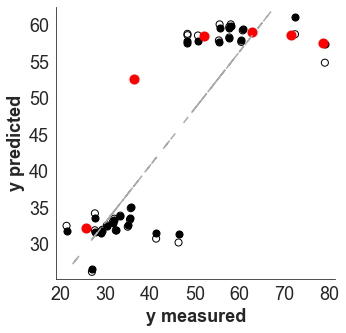

____________________________________________________________________________________
1 + x1 + x127
1 + is_sub2 + ir_OH_int_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x127

Parameters:
   43.5476 + 
   13.3813 * x1 is_sub2
   -1.5263 * x127 ir_OH_int_minE

Training R2  = 0.780
Training Q2  = 0.729
Training MAE = 4.989
Training K-fold R2 = 0.719 (+/- 0.001)

Test R2      = 0.697
Test MAE     = 9.571


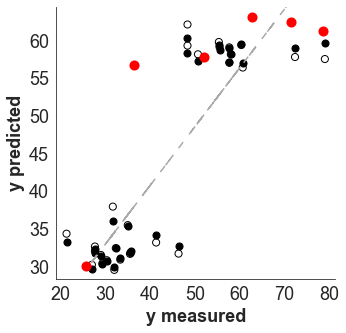

____________________________________________________________________________________
1 + x2 + x127
1 + is_sub4 + ir_OH_int_minE


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x127

Parameters:
   43.5476 + 
  -13.3813 * x2 is_sub4
   -1.5263 * x127 ir_OH_int_minE

Training R2  = 0.780
Training Q2  = 0.729
Training MAE = 4.989
Training K-fold R2 = 0.724 (+/- 0.001)

Test R2      = 0.697
Test MAE     = 9.571


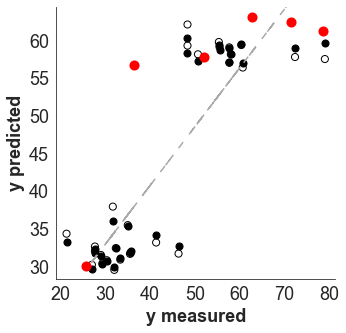

____________________________________________________________________________________
1 + x2 + x136
1 + is_sub4 + ir_CO_byOH_int_min

____________________________________________________________________________________
1 + x1 + x136
1 + is_sub2 + ir_CO_byOH_int_min

____________________________________________________________________________________
1 + x1 + x59
1 + is_sub2 + nbo_O_CObyOH_minE

____________________________________________________________________________________
1 + x2 + x59
1 + is_sub4 + nbo_O_CObyOH_minE

____________________________________________________________________________________
1 + x2 + x82
1 + is_sub4 + NBO_aryl_sub_min_boltz

____________________________________________________________________________________
1 + x2 + x86
1 + is_sub4 + NBO_aryl_sub_max_boltz

____________________________________________________________________________________
1 + x2 + x90
1 + is_sub4 + NBO_aryl_sub_avg_boltz

________________________________________________________________

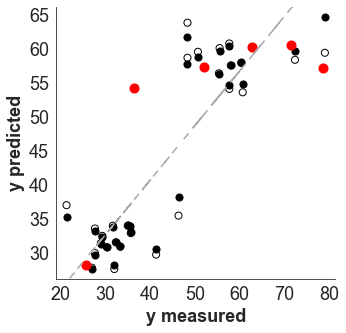

____________________________________________________________________________________
1 + x1 + x95
1 + is_sub2 + nbo_C_CObyNH_minE


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x95

Parameters:
   43.5476 + 
   13.0854 * x1 is_sub2
    2.6290 * x95 nbo_C_CObyNH_minE

Training R2  = 0.801
Training Q2  = 0.727
Training MAE = 4.938
Training K-fold R2 = 0.724 (+/- 0.001)

Test R2      = 0.666
Test MAE     = 10.065


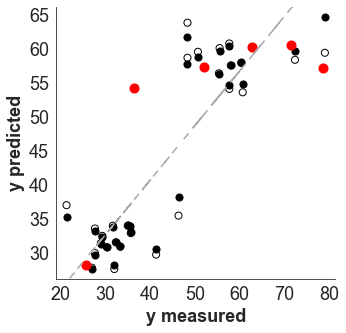

____________________________________________________________________________________
1 + x2 + x4
1 + is_sub4 + dipole_min

____________________________________________________________________________________
1 + x1 + x4
1 + is_sub2 + dipole_min

____________________________________________________________________________________
1 + x1 + x3
1 + is_sub2 + dipole_minE

____________________________________________________________________________________
1 + x2 + x3
1 + is_sub4 + dipole_minE

____________________________________________________________________________________
1 + x1 + x174
1 + is_sub2 + sterimol_CS_B1_boltz

____________________________________________________________________________________
1 + x2 + x174
1 + is_sub4 + sterimol_CS_B1_boltz

____________________________________________________________________________________
1 + x1 + x132
1 + is_sub2 + ir_CO_byOH_freq_min

____________________________________________________________________________________
1 + x2 + x132
1 +

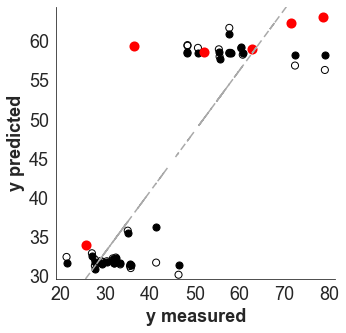

____________________________________________________________________________________
1 + x2 + x113
1 + is_sub4 + dist_OtoH_min_max


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x113

Parameters:
   43.5476 + 
  -13.2990 * x2 is_sub4
   -1.2022 * x113 dist_OtoH_min_max

Training R2  = 0.776
Training Q2  = 0.723
Training MAE = 4.899
Training K-fold R2 = 0.702 (+/- 0.007)

Test R2      = 0.652
Test MAE     = 11.021


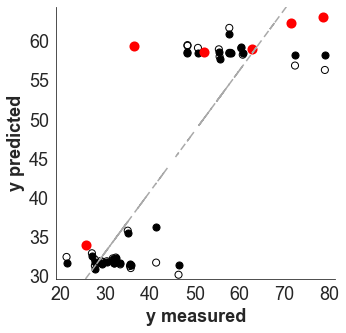

____________________________________________________________________________________
1 + x2 + x94
1 + is_sub4 + nbo_C_CObyOH_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x2 + x94

Parameters:
   43.5476 + 
  -13.4559 * x2 is_sub4
    1.2070 * x94 nbo_C_CObyOH_boltz

Training R2  = 0.776
Training Q2  = 0.723
Training MAE = 5.066
Training K-fold R2 = 0.715 (+/- 0.000)

Test R2      = 0.669
Test MAE     = 10.194


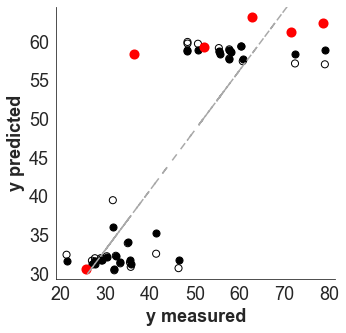

____________________________________________________________________________________
1 + x1 + x94
1 + is_sub2 + nbo_C_CObyOH_boltz


Split method: y_equidist
Test ratio: 0.2

Features: x1 + x94

Parameters:
   43.5476 + 
   13.4559 * x1 is_sub2
    1.2070 * x94 nbo_C_CObyOH_boltz

Training R2  = 0.776
Training Q2  = 0.723
Training MAE = 5.066
Training K-fold R2 = 0.716 (+/- 0.000)

Test R2      = 0.669
Test MAE     = 10.194


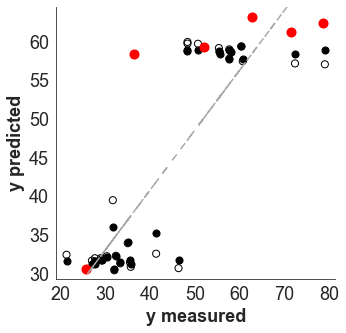

____________________________________________________________________________________
1 + x1 + x31
1 + is_sub2 + qpole_amp_minE

____________________________________________________________________________________
1 + x2 + x31
1 + is_sub4 + qpole_amp_minE

____________________________________________________________________________________
1 + x2 + x91
1 + is_sub4 + nbo_C_CObyOH_minE

____________________________________________________________________________________
1 + x1 + x91
1 + is_sub2 + nbo_C_CObyOH_minE

____________________________________________________________________________________
1 + x1 + x157
1 + is_sub2 + sterimol_NC_L_max

____________________________________________________________________________________
1 + x2 + x157
1 + is_sub4 + sterimol_NC_L_max

____________________________________________________________________________________
1 + x1 + x189
1 + is_sub2 + sterimol_SN_B5_max

____________________________________________________________________________________


____________________________________________________________________________________
1 + x1 + x13
1 + is_sub2 + homo_Elumo_max

____________________________________________________________________________________
1 + x2 + x13
1 + is_sub4 + homo_Elumo_max

____________________________________________________________________________________
1 + x2 + x21
1 + is_sub4 + homo_eta_max

____________________________________________________________________________________
1 + x1 + x21
1 + is_sub2 + homo_eta_max

____________________________________________________________________________________
1 + x2 + x97
1 + is_sub4 + nbo_C_CObyNH_max

____________________________________________________________________________________
1 + x1 + x97
1 + is_sub2 + nbo_C_CObyNH_max

____________________________________________________________________________________
1 + x1 + x32
1 + is_sub2 + qpole_amp_min

____________________________________________________________________________________
1 + x2 + x32
1 + is_

____________________________________________________________________________________
1 + x1 + x5
1 + is_sub2 + dipole_max

____________________________________________________________________________________
1 + x2 + x5
1 + is_sub4 + dipole_max

____________________________________________________________________________________
1 + x1 + x153
1 + is_sub2 + ir_NH_int_max

____________________________________________________________________________________
1 + x2 + x153
1 + is_sub4 + ir_NH_int_max

____________________________________________________________________________________
1 + x1 + x156
1 + is_sub2 + sterimol_NC_L_min

____________________________________________________________________________________
1 + x2 + x156
1 + is_sub4 + sterimol_NC_L_min

____________________________________________________________________________________
1 + x2 + x158
1 + is_sub4 + sterimol_NC_L_boltz

____________________________________________________________________________________
1 + x1 + x158
1

____________________________________________________________________________________
1 + x17 + x98
1 + homo_mu_max + nbo_C_CObyNH_boltz

____________________________________________________________________________________
1 + x10 + x106
1 + homo_Ehomo_boltz + nbo_orthoup_boltz

____________________________________________________________________________________
1 + x16 + x106
1 + homo_mu_min + nbo_orthoup_boltz

____________________________________________________________________________________
1 + x10 + x104
1 + homo_Ehomo_boltz + nbo_orthoup_min

____________________________________________________________________________________
1 + x16 + x105
1 + homo_mu_min + nbo_orthoup_max

____________________________________________________________________________________
1 + x10 + x103
1 + homo_Ehomo_boltz + nbo_orthoup_minE

____________________________________________________________________________________
1 + x16 + x103
1 + homo_mu_min + nbo_orthoup_minE

________________________________

In [147]:
# print all models that are within a specified criteria (if statement below)
# results.index will look at all models, selmods.index will look at filtered models

#for i in results.index:
for i in selmods.index:
    model_sel = results.loc[i,"Model"]
    
    #other ways of selecting models:
    # model_sel = results.iloc[selmods.index[3],0]
    # model_sel = results.iloc[785,0]
    # model_sel = ("x100","x31")
    
    
    selected_feats = sorted([X_labels.index(i) for i in models[model_sel].terms])
    X_train_sel = X_train_sc[:,selected_feats]
    X_test_sel = X_test_sc[:,selected_feats]
    print(models[model_sel].formula)
    print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[model_sel].terms])+"\n")
    lr = LinearRegression().fit(X_train_sel,y_train)
    y_pred_train = lr.predict(X_train_sel)
    y_pred_test =  lr.predict(X_test_sel)
    
    q2,loo_train = loo.q2(X_train_sel,y_train)
    kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)
    
    testr2 =  np.round(r2_val(y_test,y_pred_test,y_train),4)
    trainr2 = lr.score(X_train_sel, y_train)
    
    #set criteria here 
    if testr2 >= 0.65 and q2>=0.6:
        print("\nSplit method: {}".format(split))
        print("Test ratio: {}\n".format(test_ratio))
        
        print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
        print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))
        
        print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
        print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")
        
        print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
        print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")
    
        if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
            print("\n"+random.choice(insu))
        
        plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)
    
        #model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
        #print(model.summary())
        
    print("____________________________________________________________________________________")

# Other

## Ridge Regression, no feature selection 


Split method: y_equidist
Test ratio: 0.2

0.0001
     Training R2;Training Q2;Test R2;0.98;0.88;0.80
0.001
     Training R2;Training Q2;Test R2;0.98;0.88;0.80
0.01
     Training R2;Training Q2;Test R2;0.98;0.88;0.80
0.1
     Training R2;Training Q2;Test R2;0.98;0.88;0.79
1.0
     Training R2;Training Q2;Test R2;0.98;0.88;0.79
10.0
     Training R2;Training Q2;Test R2;0.96;0.81;0.72
100.0
     Training R2;Training Q2;Test R2;0.67;0.15;0.08
1000.0
     Training R2;Training Q2;Test R2;0.25;-0.06;-0.18
10000.0
     Training R2;Training Q2;Test R2;0.04;-0.07;-0.04


Using hyperparameter = 1.0


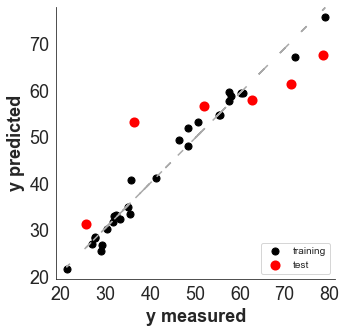

In [115]:
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

linm = Ridge().fit(X_train_sc, y_train)

r2s = []
q2s = []
parms = []
parm_range = np.logspace(-4,4,9)
for parm in parm_range:
    print(parm)
    linm = Ridge(alpha=parm).fit(X_train_sc, y_train)
    q2,loo_train = loo.q2(X_train_sc,y_train,Ridge(alpha=parm))
    
    y_pred_train = linm.predict(X_train_sc)
    y_pred_test =  linm.predict(X_test_sc)
    #print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(linm.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    #print(lr.score(X_train_sel,y_train),lr.score(X_test_sel,y_test))
        
    r2s.append(linm.score(X_train_sc, y_train))
    q2s.append(q2)
    parms.append(parm)

bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
linm = Ridge(alpha=bestparm).fit(X_train_sc, y_train)
y_pred_train = linm.predict(X_train_sc)
y_pred_test =  linm.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)   

## Lasso feature selection


Split method: y_equidist
Test ratio: 0.2

0.0001
     Training R2;Training Q2;Test R2;0.98;-121400541232503030777118720.00;0.80
     Number of features used: 133
0.001
     Training R2;Training Q2;Test R2;0.98;-693238453438743368957952.00;0.80
     Number of features used: 62
0.01
     Training R2;Training Q2;Test R2;0.98;0.90;0.80
     Number of features used: 27
0.1
     Training R2;Training Q2;Test R2;0.98;0.90;0.80
     Number of features used: 20
1.0
     Training R2;Training Q2;Test R2;0.97;0.87;0.80
     Number of features used: 12
10.0
     Training R2;Training Q2;Test R2;0.77;0.73;0.59
     Number of features used: 1


Using hyperparameter = 0.1


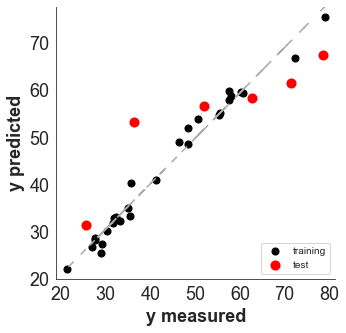



LassoLarsCV
Training R2;Training Q2;Test R2;0.94;0.91;0.79
Number of features used: 9


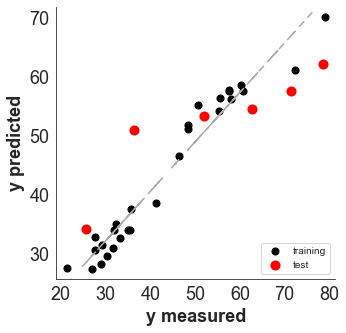

In [116]:
# Lasso feature selection
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

r2s = []
q2s = []
parms = []
parm_range = np.logspace(-4,1,6)
for parm in parm_range:
    print(parm)
    lasso = Lasso(alpha=parm).fit(X_train_sc, y_train)
    X_train_sel = X_train_sc[:,np.where(lasso.coef_!=0)[0]]
    X_test_sel = X_test_sc[:,np.where(lasso.coef_!=0)[0]]
    try:
        q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
        lr = LinearRegression().fit(X_train_sel,y_train)
        y_pred_train = lr.predict(X_train_sel)
        y_pred_test =  lr.predict(X_test_sel)
        #print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))
        print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
        #print(lr.score(X_train_sel,y_train),lr.score(X_test_sel,y_test))
    except:
        pass
    print("     Number of features used: {}".format(np.sum(lasso.coef_ != 0)))
    # print(np.where(lr.coef_ != 0)[1])
    
    r2s.append(lasso.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)

bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
lasso = Lasso(alpha=bestparm).fit(X_train_sc, y_train)
y_pred_train = lasso.predict(X_train_sc)
y_pred_test =  lasso.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)    
    
# llbic = LassoLarsIC(criterion="bic").fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(llbic.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(llbic.coef_!=0)[0]]
# print("\n\nLassoLarsIC bic")
# try:
#     q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
#     print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llbic.score(X_train_sc, y_train),q2,llbic.score(X_test_sc, y_test)))
# except:
#     pass
# print("Number of features used: {}".format(np.sum(llbic.coef_ != 0)))

# llaic = LassoLarsIC(criterion="aic").fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(llaic.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(llaic.coef_!=0)[0]]
# print("\n\nLassoLarsIC aic")
# try:
#     q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
#     print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llaic.score(X_train_sc, y_train),q2,llaic.score(X_test_sc, y_test)))
# except:
#     pass
# print("Number of features used: {}".format(np.sum(llaic.coef_ != 0)))

# lassocv = LassoCV(cv=LeaveOneOut()).fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(lassocv.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(lassocv.coef_!=0)[0]]
# q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
# print("\n\nLassoCV")
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lassocv.score(X_train_sc, y_train),q2,lassocv.score(X_test_sc, y_test)))
# print("Number of features used: {}".format(np.sum(lassocv.coef_ != 0)))
# print(np.where(lassocv.coef_ != 0)[1])

llcv = LassoLarsCV(cv=LeaveOneOut()).fit(X_train_sc, y_train)
X_train_sel = X_train_sc[:,np.where(llcv.coef_!=0)[0]]
X_test_sel = X_test_sc[:,np.where(llcv.coef_!=0)[0]]
q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
print("\n\nLassoLarsCV")
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llcv.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
print("Number of features used: {}".format(np.sum(llcv.coef_ != 0)))
# print(np.where(llcv.coef_ != 0)[1])
y_pred_train = llcv.predict(X_train_sc)
y_pred_test =  llcv.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)    



## Elastic Net


Split method: y_equidist
Test ratio: 0.2



ElasticNetCV
Training R2;Training Q2;Test R2;0.98;0.90;0.78
Number of features used: 42
Best hyperparameters: l1_ratio = 0.66, alpha = 0.1788649529057435


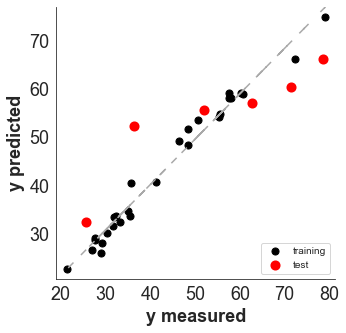

Wall time: 648 ms


In [118]:
%%time
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

encv = ElasticNetCV(l1_ratio=[.01,.05,.66,.1,.2,.3, .5, .7, .9, .95, .99, 1],
#                     n_alphas=500,
                    alphas=np.logspace(-1,4,100),
                    cv=3,n_jobs=-1,max_iter=1000000).fit(X_train_sc, y_train)
X_train_sel = X_train_sc[:,np.where(encv.coef_!=0)[0]]
X_test_sel = X_test_sc[:,np.where(encv.coef_!=0)[0]]
q2,loo_train = loo.q2(X_train_sel,y_train,Ridge(alpha=encv.alpha_))
y_pred_train = encv.predict(X_train_sc)
y_pred_test =  encv.predict(X_test_sc)
print("\n\nElasticNetCV")
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(encv.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
print("Number of features used: {}".format(np.sum(encv.coef_ != 0)))
print("Best hyperparameters: l1_ratio = {}, alpha = {}".format(encv.l1_ratio_,encv.alpha_))


plot_fit(y_train,y_pred_train,y_test,y_pred_test) 


## Orthogonal Matching Pursuit

In [119]:
# Orthogonal Matching Pursuit
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

parm_range = range(1,10)
print(np.shape(X_train_sc))
print(np.shape(y_train))
for parm in parm_range:
    print(parm)
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=parm).fit(X_train_sc, y_train)
    X_train_sel = X_train_sc[:,np.where(omp.coef_!=0)[0]]
    X_test_sel = X_test_sc[:,np.where(omp.coef_!=0)[0]]
    q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
    y_pred_train = omp.predict(X_train_sc)
    y_pred_test =  omp.predict(X_test_sc)
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(omp.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

    print("     "+" + ".join(["x"+str(i+1) for i in np.where(omp.coef_ != 0)[0]]))
    #print("     Number of features used: {}".format(np.sum(lr.coef_ != 0)))
    

# ompcv = OrthogonalMatchingPursuitCV(cv=LeaveOneOut(),n_jobs=-1).fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(ompcv.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(ompcv.coef_!=0)[0]]
# q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
# print("\n\nOrthogonalMatchingPursuitCV")
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(ompcv.score(X_train_sc, y_train),q2,ompcv.score(X_test_sc, y_test)))
# print("Number of features used: {}".format(np.sum(ompcv.coef_ != 0)))

# print("\n"+" + ".join(["x"+str(i+1) for i in np.where(ompcv.coef_!=0)[0]]))
# print("\n"+" + ".join([X_names[i] for i in np.where(ompcv.coef_!=0)[0]]))

# y_pred_train = ompcv.predict(X_train_sc)
# y_pred_test =  ompcv.predict(X_test_sc)
# plot_fit(y_train,y_pred_train,y_test,y_pred_test)



Split method: y_equidist
Test ratio: 0.2

(28, 190)
(28,)
1
     Training R2;Training Q2;Test R2;0.77;0.73;0.59
     x1
2
     Training R2;Training Q2;Test R2;0.87;0.83;0.60
     x1 + x103
3
     Training R2;Training Q2;Test R2;0.93;0.90;0.80
     x1 + x73 + x103
4
     Training R2;Training Q2;Test R2;0.95;0.91;0.79
     x1 + x73 + x103 + x152
5
     Training R2;Training Q2;Test R2;0.96;0.92;0.80
     x1 + x42 + x73 + x103 + x152
6
     Training R2;Training Q2;Test R2;0.97;0.91;0.75
     x1 + x42 + x73 + x103 + x152 + x158
7
     Training R2;Training Q2;Test R2;0.97;0.94;0.80
     x1 + x42 + x63 + x73 + x103 + x152 + x158
8
     Training R2;Training Q2;Test R2;0.98;0.94;0.79
     x1 + x32 + x42 + x63 + x73 + x103 + x152 + x158
9
     Training R2;Training Q2;Test R2;0.98;0.93;0.81
     x1 + x32 + x42 + x63 + x73 + x103 + x140 + x152 + x158


## Nonlinear Modelling

### Kernel Ridge Regression 


Split method: y_equidist
Test ratio: 0.2



KernelRidge
0.001
     Training R2;Training Q2;Test R2;1.00;0.82;0.74
0.01
     Training R2;Training Q2;Test R2;1.00;0.81;0.70
0.1
     Training R2;Training Q2;Test R2;0.97;0.71;0.60
1.0
     Training R2;Training Q2;Test R2;0.68;-0.01;-0.08
10.0
     Training R2;Training Q2;Test R2;-0.22;-0.87;-0.97
100.0
     Training R2;Training Q2;Test R2;-4.91;-5.36;-3.84
1000.0
     Training R2;Training Q2;Test R2;-8.02;-8.09;-5.75


Using hyperparameter = 0.001


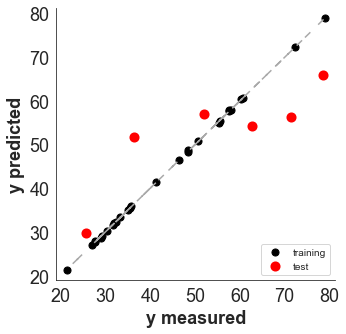

In [120]:
# Kernel Ridge Regression 
# kernel options: linear, poly, rbf
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio)) 

r2s = []
q2s = []
parms = []
print("\n\nKernelRidge")

kernel="poly" #rbf (only works if properties are related)
degree=2  #2 simulates crossterms 

parm_range = np.logspace(-3,3,7)
for parm in parm_range:
    print(parm)
    kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=parm
    ).fit(X_train_sc, y_train)
    y_pred_train = kr.predict(X_train_sc)
    y_pred_test =  kr.predict(X_test_sc)
    q2,loo_train = loo.q2(X_train_sc,y_train,KernelRidge(kernel=kernel,degree=degree,alpha=parm))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        kr.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    r2s.append(kr.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)
    
bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=bestparm
    ).fit(X_train_sc, y_train)
y_pred_train = kr.predict(X_train_sc)
y_pred_test =  kr.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)



### Support Vector Regression


Split method: y_equidist
Test ratio: 0.2



Support Vector Regression
1.00E-03
     Training R2;Training Q2;Test R2;-0.11;-0.48;-0.29
2.68E-03
     Training R2;Training Q2;Test R2;-0.11;-0.48;-0.29
7.20E-03
     Training R2;Training Q2;Test R2;-0.11;-0.48;-0.29
1.93E-02
     Training R2;Training Q2;Test R2;-0.11;-0.48;-0.29
5.18E-02
     Training R2;Training Q2;Test R2;-0.11;-0.49;-0.30
1.39E-01
     Training R2;Training Q2;Test R2;-0.10;-0.50;-0.32
3.73E-01
     Training R2;Training Q2;Test R2;-0.06;-0.52;-0.35
1.00E+00
     Training R2;Training Q2;Test R2;0.03;-0.56;-0.42
2.68E+00
     Training R2;Training Q2;Test R2;0.10;-0.45;-0.60
7.20E+00
     Training R2;Training Q2;Test R2;0.14;-0.80;-0.92
1.93E+01
     Training R2;Training Q2;Test R2;0.15;-1.47;-1.09
5.18E+01
     Training R2;Training Q2;Test R2;0.19;-2.14;-1.53
1.39E+02
     Training R2;Training Q2;Test R2;0.29;-3.10;-2.95
3.73E+02
     Training R2;Training Q2;Test R2;0.55;-6.64;-8.61
1.00E+03
     Training R2;Training Q2;Te

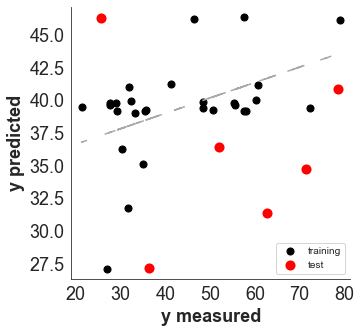

In [121]:
# SVR
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))

r2s = []
q2s = []
parms = []
print("\n\nSupport Vector Regression")

kernel="poly"
degree=2
gamma="auto"

parm_range = np.logspace(-3,3,15)
for parm in parm_range:
    print("{:.2E}".format(parm))
    svr = SVR(
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        C=parm
    ).fit(X_train_sc, y_train)
    y_pred_train = svr.predict(X_train_sc)
    y_pred_test =  svr.predict(X_test_sc)
    q2,loo_train = loo.q2(X_train_sc,y_train,SVR(kernel=kernel,degree=degree,gamma=gamma,C=parm))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        svr.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    r2s.append(svr.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)
    
bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
svr = SVR(
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        C=bestparm
    ).fit(X_train_sc, y_train)
y_pred_train = svr.predict(X_train_sc)
y_pred_test =  svr.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)
   

# keepmodels_[svr] = ()

### Regression with Principal Components


Split method: y_equidist
Test ratio: 0.2

PC Regression 1
Training R2;Training Q2;Test R2;0.03;-0.07;-0.43


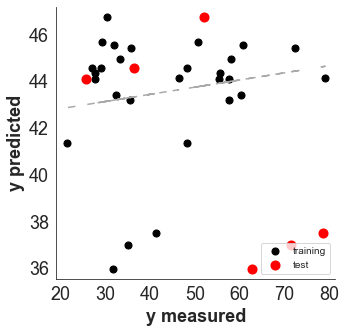


Split method: y_equidist
Test ratio: 0.2

PC Regression 2
Training R2;Training Q2;Test R2;0.12;-0.04;-0.51


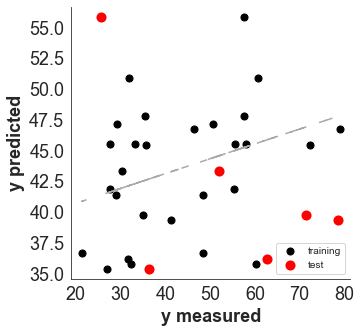


Split method: y_equidist
Test ratio: 0.2

PC Regression 3
Training R2;Training Q2;Test R2;0.14;-0.08;-0.46


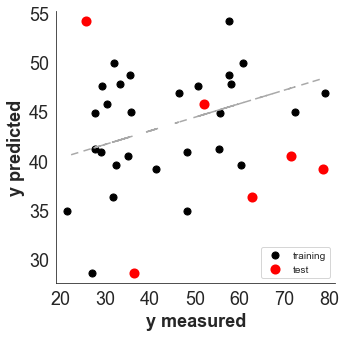


Split method: y_equidist
Test ratio: 0.2

PC Regression 4
Training R2;Training Q2;Test R2;0.16;-0.20;-0.49


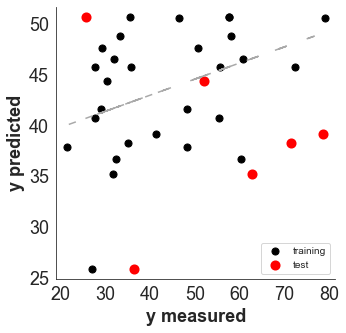


Split method: y_equidist
Test ratio: 0.2

PC Regression 5
Training R2;Training Q2;Test R2;0.22;-0.31;-0.56


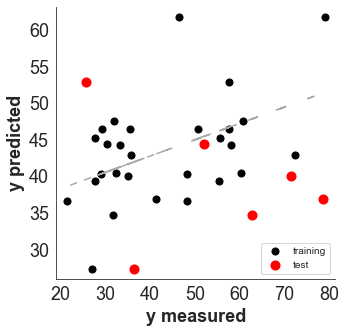


Split method: y_equidist
Test ratio: 0.2

PC Regression 6
Training R2;Training Q2;Test R2;0.22;-0.43;-0.61


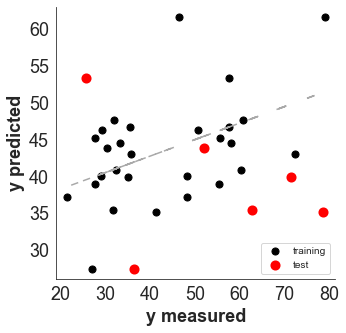


Split method: y_equidist
Test ratio: 0.2

PC Regression 7
Training R2;Training Q2;Test R2;0.24;-0.58;-0.70


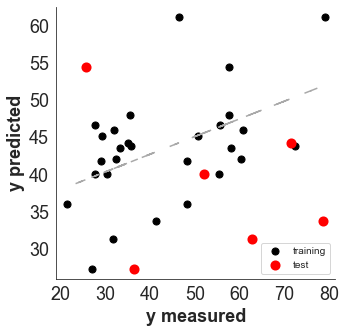


Split method: y_equidist
Test ratio: 0.2

PC Regression 8
Training R2;Training Q2;Test R2;0.28;-0.56;-0.66


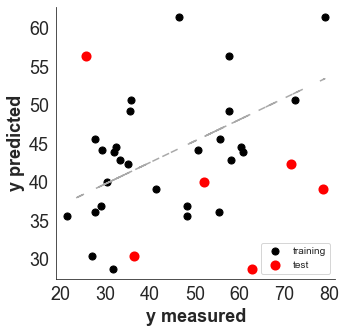

In [124]:
# Regression with Principal Components

for npca in range(1,9):
    pca = PCA(n_components=npca)
    pca.fit(scaler.transform(X_sel))
#     pca.fit(X_train_sc)
    X_train_pca = pca.transform(X_train_sc)
    X_test_pca = pca.transform(X_test_sc)

    pca_score = pca.explained_variance_ratio_
    pca_values = pca.singular_values_
    V = pca.components_

    linr = LinearRegression().fit(X_train_pca, y_train)
#     linr = Ridge(alpha=1).fit(X_train_pca,y_train)
    y_pred_train = linr.predict(X_train_pca)
    y_pred_test =  linr.predict(X_test_pca)
    q2,loo_train = loo.q2(X_train_pca,y_train,LinearRegression())
    print("\nSplit method: {}".format(split))
    print("Test ratio: {}".format(test_ratio))
    print("\nPC Regression {}".format(npca))
    print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        linr.score(X_train_pca, y_train),q2,r2_val(y_test,y_pred_test,y_train)))



    plot_fit(y_train,y_pred_train,y_test,y_pred_test)

    
# # virtual screening
# X_screen_sel = pca.transform(X_all_sc)
# y_pred_vscreen = linr.predict(X_screen_sel)
# y_vscreen["PCA5"] = y_pred_vscreen


# keepmodels_[PCA(n_components=2).fit(scaler.transform(X_sel))] = ("n_components=2")

### Random Forest


Split method: y_equidist
Test ratio: 0.2

Training R2;Test R2;0.97;0.55


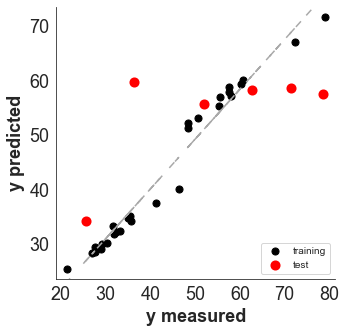

Wall time: 859 ms


In [125]:
%%time
# Random forest regression

rf  = RandomForestRegressor(n_estimators=500,random_state=42,n_jobs=None,max_features=None,max_depth=None).fit(
    X_train_sc, y_train)
# rf = GradientBoostingRegressor(
#     n_estimators=50,
#     subsample=.6,
#     max_depth=2,
#     random_state=42,
#     max_features=None,
#     alpha=0.9,
#     ).fit(X_train_sc, y_train)
y_pred_train = rf.predict(X_train_sc)
y_pred_test =  rf.predict(X_test_sc)
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))
print("Training R2;Test R2;{:.2f};{:.2f}".format(
    rf.score(X_train_sc, y_train),r2_val(y_test,y_pred_test,y_train)))
# print(np.where(llcv.coef_ != 0)[1])

plot_fit(y_train,y_pred_train,y_test,y_pred_test)   

# keepmodels_[rf] = ()